# VQE for H$_2$ molecule based on ECD-rotation ansatz

## Prerequisite

Installation cells for Google Colab users.

In [1]:
!pip install qutip
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 25.0 MB/s eta 0:00:00


In [2]:
!pip install openfermion
!pip install openfermionpyscf

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.8 MB/s eta 0:00:00
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=d27fc739d79f3846862bcf4b67021f882f565d6e340ef86d3fdf129563a73656
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 MB 53.5 MB/s eta 0:00:00


Import libaries.

In [3]:
import numpy as np
import qutip as qt
import scipy.optimize as sciopt

from scipy.linalg import expm
from functools import partial
from itertools import combinations

In [4]:
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev
from openfermion.linalg import get_sparse_operator, jordan_wigner_sparse, expectation, get_ground_state
from openfermion.ops import FermionOperator
from openfermion.ops.representations import get_tensors_from_integrals
from openfermionpyscf import run_pyscf

In [5]:
import sys

In [6]:
import matplotlib.pyplot as plt

## Basics

In [7]:
def np_arr_string(A):
    return np.array2string(A, separator=',')

In [8]:
def get_cvec_np(r, theta):
    r = np.array(r)
    theta = np.array(theta)
    return r * np.exp(1j * theta)

In [9]:
def get_r_theta_np(cvec):
    cvec = np.array(cvec)
    r = np.abs(cvec)
    theta = np.angle(cvec)
    theta = np.where(theta < 0, theta + 2*np.pi, theta)
    return r, theta

In [10]:
def unpack_params_np(X):
    # Initialize
    dim = X.shape[0] // 4

    # Unpack
    beta_mag = X[:dim].copy()
    beta_arg = X[dim:2*dim].copy()
    theta = X[2*dim:3*dim].copy()
    phi = X[3*dim:4*dim].copy()

    return beta_mag, beta_arg, theta, phi

In [11]:
def pack_params_np(beta_mag, beta_arg, theta, phi):
    # Initialize
    dim = beta_mag.shape[0]
    X = np.zeros((4 * dim,))

    # Pack
    X[:dim] = beta_mag.copy()
    X[dim:2*dim] = beta_arg.copy()
    X[2*dim:3*dim] = theta.copy()
    X[3*dim:4*dim] = phi.copy()

    return X

## Ansatz

Elementary operator matrices.

In [12]:
def identity_np(N):
    return np.eye(N)

def basis_np(N, j):
    V = np.zeros(N)
    V[j] = 1.0
    return V

def destroy_np(N):
    op = np.diag(np.sqrt(np.arange(1, N)), k=1)
    return op

def create_np(N):
    return np.conj(destroy_np(N)).T

def sigmax_np():
    return np.array([[0 + 1j*0, 1], [1, 0]])

def sigmay_np():
    return np.array([[0, -1j], [1j, 0]])

def sigmaz_np():
    return np.array([[1, 0], [0, -1]])

def qproj00_np():
    return np.outer( basis_np(2, 0), basis_np(2, 0) )

def qproj11_np():
    return np.outer( basis_np(2, 1), basis_np(2, 1) )

def qproj01_np():
    return np.outer( basis_np(2, 0), basis_np(2, 1) )

def qproj10_np():
    return np.outer( basis_np(2, 1), basis_np(2, 0) )

def hadamard_np():
    return (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])

In [13]:
def displace_np(N, alpha):
    """
    D (alpha) = exp( alpha b! - alpha* b ).

    Arguments:
    alpha -- displacement parameter
    N -- Fock cutoff
    """
    gen = ( alpha * create_np(N) )
    gen -= ( np.conj(alpha) * destroy_np(N) )

    return expm(gen)

In [14]:
def rotation_np(theta, phi):
    """
    R (theta, phi) = exp[ −i (theta/2) ( X cos(phi) + Y sin(phi) ) ].

    Arguments:
    theta, phi: rotation parameters
    """
    gen = ( sigmax_np() * np.cos(phi) )
    gen += ( sigmay_np() * np.sin(phi) )

    H = -1j * (theta / 2) * gen

    return expm(H)

ECD-rotation operator matrix is defined as

$$ U (\beta, \theta, \phi)
= ECD (\beta) \: \big[ R (\theta, \phi) \otimes I \big]
= \begin{bmatrix}
e^{i \: (\phi - \pi/2)} \: \sin ( \theta/2 ) \: D^\dagger (\beta/2) &
\cos ( \theta/2 ) \: D^\dagger (\beta/2)
\\
\cos ( \theta/2 ) \: D (\beta/2) &
- e^{- i \: (\phi - \pi/2)} \: \sin ( \theta/2 ) \: D (\beta/2)
\end{bmatrix},
$$
where the operators are

\begin{align*}
R (\theta, \phi)
&= e^{ - i (\theta / 2) \big[ \cos(\phi) X + \sin(\phi) Y \big] },
\\
ECD (\beta)
&= |1 \rangle \langle 0| \otimes D (\beta / 2)  
+ |0 \rangle \langle 1| \otimes D (-\beta / 2),
\\
D (\alpha)
&= e^{ \alpha a^\dagger - \alpha^* a }.
\end{align*}

In [15]:
def ecd_rot_op_np(beta, theta, phi, nfock):
    """
    O = ECD(beta) (R (theta, phi) x I ).

    Reference DOI: 10.1038/s41567-022-01776-9.

    Arguments:
    beta -- ECD parameter
    theta, phi -- rotation parameters
    nfock -- number of qumode levels
    """
    ECD = np.kron(qproj10_np(), displace_np(nfock, beta/2))
    ECD += np.kron(qproj01_np(), displace_np(nfock, -beta/2))
    R = np.kron(rotation_np(theta, phi), identity_np(nfock))
    A = np.matmul(ECD, R)

    return A

In [16]:
def ecd_ansatz_np(beta, theta, phi, nfock):
    """
    ECD-rotation blocks.

    Arguments:
    beta -- Nb ECD parameters
    theta, phi -- Nb rotation parameters
    nfock -- number of qumode levels
    """
    # Check
    if beta.shape != theta.shape:
        raise ValueError("Lengths of beta and theta do not match.")
    if beta.shape != phi.shape:
        raise ValueError("Lengths of beta and phi do not match.")

    # Initialize
    ndepth = beta.shape[0]
    uni = ecd_rot_op_np(beta[0], theta[0], phi[0], nfock)

    # Check
    if ndepth == 1:
        return uni

    # Loop through blocks
    for j in range(1, ndepth):
        new_uni = ecd_rot_op_np(beta[j], theta[j], phi[j], nfock)
        uni = ( np.matmul(new_uni, uni ))

    return uni

In [17]:
def ecd_circuits_np(beta_mat, theta_mat, phi_mat, nfock):
    nterms = beta_mat.shape[0]
    Uten = np.zeros((nterms, 2 * nfock, 2 * nfock,), dtype=np.complex128)
    for i in range(nterms):
        Uten[i, :, :] = ecd_ansatz_np(beta_mat[i, :], theta_mat[i, :], phi_mat[i, :], nfock)
    return Uten

## Hamiltonian

\begin{align*}
H_Q
&= g_1
+ g_2 \: ( Z_0 + Z_1 )
+ g_3 \: ( Z_2 + Z_3 )
+ g_4 \: Z_0 Z_1
+ g_5 ( Z_0 Z_2 + Z_1 Z_3 )
+ g_6 ( Z_0 Z_3 + Z_1 Z_2 )
\\
&+ g_7 \: Z_2 Z_3
+ g_8 ( X_0 Y_1 Y_2 X_3
+ Y_0 X_1 X_2 Y_3
- X_0 X_1 Y_2 Y_3
- Y_0 Y_1 X_2 X_3 )
\end{align*}

### Imported data

Data for $N_d = 10$ and $N_t = 15$.

In [18]:
P2_nd10nt15_loss = 4.648113941583964e-12

P2_nd10nt15_C = np.array([-0.63475064, 0.65522057, 0.61593177,-0.64862854, 0.75282843,-0.35141614,
  0.50924009,-0.88948318, 0.81901756, 0.53633957, 0.68173731, 0.67250993,
  0.51252348, 0.52638004, 0.66961853])

P2_nd10nt15_beta = np.array([[ 4.46214956e-01+0.71104796j, 2.19081171e-01+1.61482673j,
  -3.34433779e+00-0.88134083j,-7.56789145e-01+0.61117082j,
  -3.01055932e+00+0.05669254j,-1.97696858e+00+1.31787949j,
  -5.19009771e-01+0.2008542j , 5.74583827e-01+0.05903441j,
   2.68680962e-01-0.03967181j,-2.16166042e+00-0.12030353j],
 [-2.68799677e-02+1.15513901j, 1.55083831e+00+1.34800524j,
   1.05568210e+00+2.36442933j, 5.94230629e-01+1.35718497j,
  -9.74350397e-01+0.65303809j,-1.93971965e-01+1.74868232j,
  -2.24114674e+00-0.0070298j ,-1.20620014e-01+0.58580454j,
   1.49560602e+00+1.77326423j, 1.01333884e+00+2.7590262j ],
 [ 1.59205225e+00+2.08508307j,-1.68158562e+00+1.52301028j,
  -1.44639048e+00+1.77005597j, 2.12354407e-01-0.08747979j,
  -2.28972474e+00+0.25969069j,-1.28456346e+00+1.94450419j,
   9.45320127e-01+0.71882213j,-7.62305859e-01+0.30598755j,
  -2.09006226e+00+0.55245669j, 2.03511824e+00-0.11654545j],
 [ 1.88206192e+00-0.47983201j,-1.86281027e+00+1.77449578j,
   9.40767155e-01+1.37523072j, 8.03841924e-02+0.56252233j,
   7.79355859e-02-0.19413725j, 1.38891009e+00+1.70305509j,
  -1.69310760e+00+0.32318269j, 2.18116287e+00+1.59098631j,
  -1.04427905e+00+2.10223866j, 6.93160433e-02+2.92846307j],
 [ 1.58022781e+00+1.53543122j,-1.39391460e+00+0.50027693j,
   5.17850913e-02+0.0235592j ,-2.22829916e+00+1.0213977j ,
  -4.67882147e-01+1.11385131j, 1.62998973e+00+1.13292806j,
   3.04750739e+00+0.09586239j,-3.94255294e-01+0.3415942j ,
   9.79843069e-02+2.68002935j,-5.35080653e-01+0.76797056j],
 [ 1.46360487e-01+0.95249466j, 6.04418343e-01+0.82695986j,
   2.73996169e-01+0.42364905j, 4.56560192e-01+0.54438532j,
  -4.39152744e-01+1.24083745j, 1.12033749e+00+1.38240682j,
   2.96119460e-03+1.66807209j,-2.45298227e+00+1.50217964j,
   5.74895290e-01+0.80549804j,-6.73731191e-01+0.38527534j],
 [ 2.00902139e+00-0.04036352j,-7.72332718e-01+0.37537479j,
   3.21975276e-01+0.61943592j, 9.53357121e-01+0.70081466j,
   5.74399251e-01+0.20053292j,-4.41496655e-02+2.40406752j,
  -1.55285000e-01-0.67888226j,-1.20235496e+00+0.09968957j,
  -1.78448751e+00-1.75480137j,-7.71259915e-01+0.51220724j],
 [-1.16713534e+00+1.00741856j,-2.81026635e+00+0.44241678j,
   1.39831527e+00+1.9372758j ,-1.70351727e-01+0.17189572j,
   4.50677549e-01+2.07428003j,-1.63635005e+00+0.24962536j,
  -1.70390865e+00+0.93321537j, 4.87322638e-01+0.31166362j,
   2.00061907e+00+0.83026649j, 1.47621769e+00+1.34322263j],
 [-9.92074273e-01+1.77367557j, 8.12383260e-01+0.44972415j,
  -5.28736924e-01+0.13381289j,-7.44334910e-01+0.02451329j,
  -1.11104405e+00+3.14197901j, 6.22378965e-01+0.23869327j,
  -5.98417222e-02+2.97957461j,-2.63732055e-01+1.36929353j,
   5.11959649e-01+0.14762909j,-1.61884598e-01+1.10000033j],
 [ 3.93193942e-03+0.16969972j, 4.11655906e-01+2.03976951j,
  -4.11946422e-01+0.32145712j,-9.31200918e-01+0.05361991j,
   1.00011753e+00+0.37643163j,-9.03011166e-01+0.75796981j,
  -1.58494257e+00+0.37345582j,-1.17025655e+00+1.37947309j,
  -1.20397799e+00+2.34283242j,-2.57227889e-01+1.42904864j],
 [ 1.80094472e+00+0.03747447j,-1.89472081e+00+1.55676092j,
   1.75643763e+00+0.19942994j,-1.19397348e+00+1.05773502j,
   9.17966408e-01+1.0819032j ,-1.20043751e+00-0.17676681j,
  -1.21069758e+00+2.18587973j, 2.38607098e-01+2.22188081j,
  -1.55399757e+00+0.06445874j, 1.73141443e+00+2.46404451j],
 [ 4.77114502e-01+2.43844918j,-1.27633625e+00+1.57515231j,
   2.27467265e-01+2.6368298j , 1.26038333e+00-0.22959125j,
   5.53772192e-01+1.51497061j,-2.61919842e+00+1.00647775j,
  -2.17264733e-01+0.9769852j , 2.66336012e-01+1.61641677j,
  -7.12043186e-01+0.56027847j,-8.28623610e-01+1.25843583j],
 [ 1.33488542e+00+0.91680674j, 2.49947842e+00+0.74663522j,
   4.44091937e-01+1.23638153j, 2.87865370e+00+1.32398063j,
  -5.70146727e-01+1.33223792j,-3.23709236e-01+1.53391506j,
  -2.78180019e+00-0.00765994j, 1.48690643e+00+0.68332963j,
  -1.49583539e+00+1.37138203j, 3.82059472e-01+0.10586992j],
 [ 3.61838286e-01+0.31745116j, 9.94997565e-01+1.84481946j,
   2.03591450e+00+1.74106342j,-6.38883850e-01+0.54175904j,
  -1.51634785e+00+0.5197406j , 6.24254436e-02+0.14944706j,
  -9.65101667e-01+2.41254305j, 1.32223997e+00+2.20376017j,
   1.07635243e+00+1.09263196j, 6.76352947e-01+0.06271684j],
 [-2.36199280e+00+0.66013724j,-1.57115722e-01+1.91688435j,
   5.16652866e-02+0.06655447j,-5.67734788e-01+0.4785466j ,
  -7.69905401e-02+1.16103662j,-1.05932125e+00+0.18657897j,
   1.02190040e-01+0.75752809j, 2.00083411e+00+2.73409342j,
  -3.80145044e-01+0.70503827j,-4.57525974e-01+1.03828716j]])

P2_nd10nt15_theta = np.array([[ 2.32392684, 1.09492934, 2.98342071, 1.43987379, 1.32460215, 0.72940799,
   0.49821089, 2.9703713 , 2.12851566,-0.30200625],
 [ 2.6193144 , 0.53733822, 1.92347527, 1.82871204, 0.2054585 , 0.26010106,
   1.92305677, 2.15494906, 1.00458553, 2.23831208],
 [ 1.31845295, 1.71044168, 1.33727698, 2.82038618, 2.65035311, 1.35083728,
   2.27765906, 2.23283383, 1.21896105, 0.85115098],
 [ 2.46736379, 1.77011397, 0.08705531, 3.20361652, 2.26605677, 1.67597697,
   2.91505939, 2.14549651, 1.15779175, 3.1366956 ],
 [ 2.48032266, 0.73152743, 0.22167757, 3.40006979, 1.41444106, 0.80355722,
   1.18421035, 1.3360973 , 0.81299097, 0.60891944],
 [ 0.38879687, 1.66251543, 1.46751377, 2.38388688, 1.6265357 , 0.82856988,
   1.78019789, 0.99936566, 2.25633137,-0.9730574 ],
 [ 2.4529639 , 2.71459772, 1.10675951, 2.17393845, 0.85260498, 0.20428411,
   1.33017587, 2.54595124, 2.34964938, 0.7094082 ],
 [ 2.4938626 , 0.85465471, 2.85528172, 0.94729574, 0.84507961, 0.47986728,
   2.78146774, 1.9328511 , 1.97553378, 3.0570512 ],
 [ 2.71060001, 1.18793443, 2.08800903, 2.61709977, 1.9369189 , 2.18812426,
   1.48557475,-0.21577992, 2.55038495, 0.46154186],
 [ 0.56474272, 1.80397882, 1.58384023, 2.04387613, 2.15159505, 2.60090421,
   2.76796957, 1.51610283, 2.97551074, 0.38309839],
 [ 0.37443917, 1.30994494, 0.69435145, 2.6787291 , 1.08827391, 1.25209334,
   0.99245231, 2.83702695, 1.13154877, 1.22892158],
 [ 3.15971772, 2.10299386, 1.89110267, 1.53340298, 1.43334496, 2.33660981,
   0.76688429, 3.05563245, 0.75271607, 1.19329797],
 [ 1.1287476 , 1.7436825 , 2.0741323 , 1.03882484, 2.46749916, 2.05864383,
   3.537788  , 1.11694755, 2.18536   , 2.4790424 ],
 [ 2.8445855 , 0.96274107, 2.27511927, 0.61024182, 1.55409282, 2.38211999,
   1.3580971 , 2.90555016, 0.85576974, 0.34382655],
 [ 1.10040303, 1.17667058, 0.49193853, 2.40287062, 1.70550958, 1.2638394 ,
   2.06177592, 1.30273978, 1.38469921, 1.07999725]])

P2_nd10nt15_phi = np.array([[ 2.78359629, 2.51419322, 1.55935073, 2.2884308 , 3.50402566, 0.60445059,
   1.78578604, 3.30315026, 0.19434128, 0.49233592],
 [ 0.60186534, 2.71144481, 2.20347168, 2.53759248, 1.13106707, 1.09417967,
   0.67641486, 0.80566673, 0.5544031 , 1.66097164],
 [ 1.88919256, 1.14330838, 1.19119995, 1.97335732, 2.45096622, 0.6966937 ,
   2.01493883, 2.35527129, 0.08544549, 0.65523085],
 [ 0.12380366, 0.61064869, 0.44728537, 2.10006724, 1.51799924, 1.34041052,
   0.7527136 , 1.69402795, 2.15015838, 2.94440749],
 [ 0.73336047, 2.08809412, 1.39594315, 0.39324285, 2.11994477, 1.64193858,
   1.19794816, 1.78566222, 1.97872284, 0.12740623],
 [ 2.70578484, 2.31667726, 1.03210338,-0.25795002, 0.26147187, 1.88641454,
   1.98544896, 2.13144155, 0.75605223, 2.71461053],
 [ 0.89004451, 0.53496874, 0.55490529, 1.17604448, 0.14470306, 0.30728947,
   1.35877204, 1.1682389 , 1.25797818, 1.9839802 ],
 [ 0.22389096, 0.76140494, 1.14473581, 2.64242365, 0.88247509, 0.61084758,
   1.91355675, 1.01809299, 2.10703648,-0.07305355],
 [ 1.0225094 , 0.76339126, 0.49060216, 2.40225577, 1.41662532, 1.96552055,
   1.7329898 , 1.15679751, 2.83919817, 1.83907908],
 [ 1.56891867, 0.65192823, 0.31080331, 0.46483449, 1.50790244, 0.25051812,
   1.49259261, 2.56867022, 2.32776604, 1.21553432],
 [ 1.55795609,-0.17718511, 1.25098351, 2.79290326, 1.47469202, 2.7254812 ,
   2.59038321, 2.5083388 , 2.49794471, 1.26707089],
 [ 0.5486976 , 0.35291001, 0.7334306 , 2.28877993, 0.95740168, 2.16513927,
   0.87261942, 0.54645074, 0.64748873, 3.17420604],
 [ 1.54659162, 2.44571193, 0.06570127, 2.05112854, 2.78005234, 1.92776459,
   1.17856586, 2.88160821, 0.43512133, 1.46273193],
 [ 0.77319687, 2.44812333, 2.75950391, 2.09022686, 2.45668169, 0.75221151,
   0.40711152, 2.51058212, 0.0850117 , 2.22405306],
 [ 0.4684327 , 1.090827  , 3.28385633, 1.55086506, 3.26520043, 2.74174966,
   0.14427663, 2.5535265 ,-0.14364052, 0.81620826]])

In [19]:
P3_nd10nt15_loss = 3.153134906579826e-11

P3_nd10nt15_C = np.array([-1.25795184, 0.94233072, 1.23309813,-0.9046831 ,-1.06720492, 1.50677038,
  0.91668547, 1.01757734, 0.73496698, 1.00525865, 1.07731026,-1.14503963,
 -1.18501993, 0.79723318, 0.96810792])

P3_nd10nt15_beta = np.array([[ 1.99221996+1.76016030e+00j,-3.07982637+7.37170300e-01j,
   0.84959981+9.74592576e-01j,-1.14820166+2.16212751e+00j,
   1.34087309+1.48651429e+00j,-0.20633745+1.41621178e+00j,
   1.00815028+2.80157261e+00j,-2.04344838+3.55346068e-02j,
   2.41431855+1.35440551e+00j,-0.79020148+8.37595254e-01j],
 [-0.98317108+1.56061639e+00j,-0.68608307+1.44813480e-01j,
   2.8337976 +7.28788463e-01j, 0.17843721+2.25859801e-01j,
   0.83097127+6.14066225e-01j, 0.06233137+3.37224500e-01j,
   1.83802177+1.11412907e-01j, 2.56275188+1.75941645e+00j,
  -0.94804269+1.38656659e+00j,-1.19015937+1.91501221e+00j],
 [-0.79907268+2.61019993e-01j,-0.43624017+7.52478194e-01j,
   0.93289438+4.73268448e-01j, 2.03396743-5.51726908e-01j,
  -0.57147642+3.28715606e-01j, 0.30477757+2.76118007e+00j,
  -0.19165343+2.38950097e+00j,-0.68845713+2.10843282e-01j,
   0.23359519-1.06517268e-02j, 0.16353077-1.79359174e-01j],
 [-0.01938232-2.99946175e-02j,-1.82248871+1.65314917e+00j,
   0.88723246+8.24807285e-03j, 0.3787434 +5.54781776e-01j,
  -0.34127221+7.29458564e-01j,-0.0495501 +7.20502611e-02j,
   1.08131351+1.78945703e+00j, 0.51699209+3.15878912e+00j,
   1.88507145+2.24835472e+00j, 2.33180234+1.51125732e+00j],
 [-2.88628774+8.60804335e-01j,-0.25383967+2.40391759e+00j,
   2.16804187+7.71276419e-01j,-0.25954341+7.49629315e-01j,
   0.59332863+6.06065462e-01j,-0.83783127+2.07034502e+00j,
   0.10907923+1.12384415e+00j, 1.52389862+2.16694956e+00j,
  -0.91818663+1.95724789e+00j, 1.1285975 +2.23065835e+00j],
 [ 0.04129208+3.52321213e-01j, 0.67782163+5.60119695e-01j,
   0.32738553+8.54768249e-01j,-0.87641364+3.36332186e-01j,
  -0.50762697+1.81916144e+00j,-1.14328311+1.36007392e+00j,
  -1.17538426+1.31808489e+00j, 0.1023503 +9.44242867e-01j,
   1.92385256+2.53858363e+00j, 0.33864836+4.93865766e-01j],
 [ 0.56237146+6.45779779e-01j, 2.68172574+1.20671217e+00j,
  -2.17333761+1.87578686e+00j, 0.7155169 +2.05968162e+00j,
   1.00779135+1.40256341e+00j,-1.10227705+1.97518286e-01j,
  -2.18401129+9.89137687e-01j,-0.0139258 -2.44899910e-02j,
  -0.76032063+9.67994450e-01j, 0.17840711+4.17195461e-01j],
 [ 0.86460142+2.83502907e+00j, 0.50685078+2.96366553e-01j,
  -0.13171543+1.28280721e+00j, 2.50348842+2.01575892e+00j,
   0.33894382+1.06107351e+00j, 0.78299779+2.34914155e+00j,
  -0.04254494-1.75302408e-03j, 1.81526391+1.28634972e+00j,
  -0.34575275+1.58442604e+00j,-1.76582708-4.04383003e-01j],
 [ 2.8830695 -6.62572516e-01j, 1.13052604+1.40633350e+00j,
  -0.45211298+1.16095357e-01j, 0.04406955-2.00951096e-01j,
  -0.61154719+1.13690153e+00j,-1.80511619+2.47778351e+00j,
   0.93090791+4.70329654e-01j, 1.16633126+1.18255603e+00j,
  -1.16110319+2.52756358e+00j, 1.11613775-3.36542465e-01j],
 [-1.75550385+2.54825364e-01j,-1.16887936+8.12278195e-01j,
   0.59117481+3.28036731e-01j,-1.14697629+2.51441063e+00j,
   1.40033152+1.55522317e+00j,-2.9890283 +1.54621844e+00j,
  -0.4933353 +1.48534045e+00j,-0.02858944+3.14504833e-02j,
   1.41537601+1.63156301e+00j,-1.5431812 +3.18403824e-01j],
 [ 3.07557084+1.58513340e+00j,-1.3359018 +1.78268791e+00j,
  -0.09190647+1.44861215e+00j,-1.64343138+5.83212651e-01j,
  -2.54771255+8.81084529e-01j, 1.07967898-9.78012170e-02j,
   0.24205414+1.22922057e+00j, 2.2881105 +2.17947660e+00j,
  -0.36889467+1.95008453e-01j,-1.13536629+2.51523045e-01j],
 [-0.13541914+6.85028206e-02j, 0.59186648+3.37607203e-01j,
   0.19586322-4.26314702e-01j,-1.01133807+2.17745452e+00j,
  -0.2075031 +2.96934023e-01j, 0.64651797+2.29616385e+00j,
  -0.83406971+1.56887821e-01j,-0.28903847+7.54590138e-01j,
   0.27431354+5.21013413e-01j,-0.04363259+2.95745474e-02j],
 [-0.56227176+5.47659108e-01j, 0.14965733+4.84401552e-02j,
  -0.43120309+5.25873822e-01j, 0.0423309 -6.70476728e-02j,
  -1.44321916+1.12998283e-01j,-1.25637241+5.29956113e-01j,
   1.05896703+6.21074652e-01j, 0.02050173+6.12483470e-01j,
  -2.34424196+5.32551593e-01j, 0.72285276+1.18533435e+00j],
 [-1.13064303+1.80061552e+00j,-3.06351622+8.25432938e-01j,
  -1.27988647+2.54415054e-01j,-1.15865644+9.34820916e-01j,
  -0.52972158+3.63380300e-01j,-0.15511054+8.00340845e-01j,
  -0.09179617+9.69097457e-01j, 1.12211272+1.91471431e-01j,
   0.73427399+1.22422547e+00j, 0.01391239-3.80605029e-01j],
 [-1.80502071+7.32298986e-01j, 0.33112462+1.48872655e+00j,
  -0.07209888+1.14776664e+00j, 0.22891032-4.57898931e-02j,
   1.58825626+1.16625547e-01j, 2.86234737-2.88940701e-02j,
   1.28215808+1.61926357e-01j,-0.90515609+8.77103391e-01j,
  -0.54477071+2.52956166e+00j,-2.43624975+9.81932387e-01j]])

P3_nd10nt15_theta = np.array([[ 1.0943443 , 2.98614575, 1.13084538, 2.38155342, 2.10529715, 2.46506179,
   1.33973886, 1.48509551, 1.67872696, 2.62870666],
 [ 1.71447878, 0.47546403, 1.63223075, 0.43825933, 2.16999466, 1.28447357,
   1.78799664, 2.48135671, 2.62153007, 3.57326154],
 [ 2.6727432 , 2.66662256, 2.0499436 , 2.90586169, 2.18911952, 1.65692352,
   2.32945477,-0.38296478,-0.81532917, 1.72523805],
 [ 2.32551904, 1.86901487, 0.20449845, 0.56936001, 1.18281443, 0.27863067,
   0.82023481, 1.77991022, 1.0738933 , 1.2312331 ],
 [ 2.1577967 , 2.69850993, 0.71574377, 0.44519598, 1.36789151, 1.93420695,
   1.51877005, 1.10209528, 0.63977903, 1.60111053],
 [ 2.7831035 , 2.03292207, 2.45776042, 2.27811337, 2.19773568, 0.22479246,
   1.31474923, 0.67765367, 0.75770687, 1.8398673 ],
 [ 2.74038806,-0.32743658, 1.34962738, 1.73434553, 0.68350244, 0.93488647,
   1.22656262, 0.28233457, 0.56549283, 0.65438921],
 [ 1.05182086,-0.39632607, 0.7263686 , 2.76038009, 1.53752224, 1.99208484,
   1.78754738, 0.87737291, 2.61729871, 0.66664956],
 [ 0.23282368, 1.38305385,-0.32523707, 2.45021654, 1.07894778, 2.42851704,
   1.5051416 , 2.37698917, 2.68389078, 0.40193726],
 [ 1.88248823, 0.52124083, 1.73476431, 1.81419894, 1.26112239, 1.84996559,
   1.41878265,-0.19029931, 3.024264  , 2.0759494 ],
 [ 0.83276609, 2.06578828, 2.18127638, 1.70447376, 0.75947927, 1.07153763,
   3.63993854, 0.67342539, 1.66020908, 2.59751315],
 [ 2.49270804, 2.09686668, 0.65455629, 2.35024822, 1.97305297, 0.62277521,
   1.39990342, 1.08244676,-0.72637062, 1.93595728],
 [ 1.05707449, 2.39452147, 1.56767842, 2.40190439,-0.05150221, 0.85669118,
   1.32399254, 1.69740946, 1.51318133, 1.35041328],
 [ 2.66912762, 1.64551402, 2.03007657, 3.00759661,-0.26872122, 1.80764947,
   0.70791263, 0.2876846 , 1.356892  , 2.56037046],
 [ 2.13170206, 2.40897903, 1.99791923, 0.41447775, 3.11104446, 0.90493088,
   0.58104616, 3.45306545, 1.39697829, 0.98916256]])

P3_nd10nt15_phi = np.array([[ 5.93505552e-01, 1.51136868e+00, 2.01432773e+00, 2.65289527e+00,
   9.61093214e-02, 1.08771788e+00, 5.32189186e-01, 1.43313094e+00,
   5.52223715e-02, 2.71675435e+00],
 [ 5.93792237e-01, 5.97407290e-01, 9.92358259e-01, 1.16288136e+00,
   2.70374663e+00, 1.55858752e+00, 1.90551756e+00, 2.12709261e+00,
   2.08317728e+00, 1.63294050e+00],
 [ 1.55835070e+00, 1.97538359e+00, 1.85660327e+00, 4.86090027e-01,
  -4.74872564e-02, 3.03089776e+00, 1.45786214e+00, 2.11173370e+00,
   2.40746472e+00, 2.62326522e+00],
 [ 1.20342514e+00, 1.32103820e+00, 1.84837527e+00, 1.43551850e+00,
   3.51403645e-01, 1.26899393e+00, 1.51624246e+00, 5.94667056e-01,
   1.12414601e+00, 2.63157611e+00],
 [ 7.40084107e-01, 2.08303526e+00, 1.80061202e+00, 2.36042138e+00,
   1.59136050e+00, 7.92807239e-01, 2.35454276e+00, 1.12390489e+00,
   2.07344748e+00, 1.87408352e+00],
 [ 1.47719139e+00, 7.67466130e-01, 5.91418178e-01, 2.62539951e+00,
   5.80031273e-01, 2.09300335e+00, 4.86316217e-01, 2.11470766e+00,
   4.47268984e-01,-2.32558312e-01],
 [ 2.35591023e+00, 6.75586040e-01, 2.49525738e+00, 1.72621597e+00,
   2.30730033e+00, 1.08979133e+00, 2.52355751e+00, 2.85776340e+00,
  -1.29291189e-02, 1.65052352e+00],
 [ 6.12373234e-01, 1.91417626e+00, 1.59541759e-01, 1.38887573e+00,
   4.15716280e-02, 6.71807515e-01, 2.46364867e+00, 2.47553818e+00,
   6.10834543e-04, 1.64374720e+00],
 [ 4.33136674e-01,-4.86551112e-01, 2.64543255e-02, 6.15525185e-01,
   1.09415718e+00, 1.83316712e+00, 1.34050676e+00, 1.59907503e+00,
   1.04661907e+00, 2.41429741e+00],
 [-1.13781851e-01, 2.81769001e+00, 2.90634719e+00, 1.73024510e+00,
   1.38408494e-01, 2.14770990e+00, 2.86557256e+00, 1.13136287e+00,
   1.70438856e+00, 2.29586998e+00],
 [ 1.42171796e+00, 9.96116206e-01, 3.33107645e+00, 1.40185967e+00,
   1.12044434e+00, 1.30791064e+00, 6.24640817e-01, 7.26219434e-01,
   1.30875467e+00, 3.03548559e+00],
 [ 2.02029864e+00, 1.65386462e+00, 8.52289736e-02, 2.29171174e+00,
   1.00038524e-01, 1.75152024e+00, 1.96157947e+00, 2.99913620e-02,
   1.56829594e-01, 3.01012310e+00],
 [ 4.53754211e-01, 1.36784947e+00, 3.31799988e-02, 1.67472279e+00,
   3.02213671e+00, 8.87744729e-01, 4.75696160e-01, 2.79508636e+00,
   2.20588943e+00, 3.51334503e-01],
 [ 2.67986241e+00, 2.81969082e+00, 2.55587134e+00, 1.22602884e+00,
   2.13044638e+00, 1.72207335e+00, 2.68401004e+00, 2.89300495e+00,
   1.19121264e+00, 2.46082682e+00],
 [ 9.85105474e-01, 2.52298240e+00, 2.37257042e+00, 1.25367752e+00,
   1.13946604e+00, 1.38174199e+00, 1.41970184e+00, 2.46323550e+00,
   6.16837921e-01, 3.53605527e-01]])

In [20]:
P4_nd10nt15_loss = 4.659614250995868e-12

P4_nd10nt15_C = np.array([ 0.41314846, 0.38589592,-0.46096199,-0.63754082, 0.52883403,-0.52444996,
  0.52168244, 0.43808154,-0.38154287, 0.42522735,-0.47156708, 0.53552124,
 -0.6992929 ,-0.42653109, 0.50142624])

P4_nd10nt15_beta = np.array([[ 2.09015853e+00+5.21797320e-01j, 1.09001110e+00+1.13214001e+00j,
   3.87791607e-01+2.30040675e-01j,-8.22974720e-01+8.64318449e-01j,
   7.97696193e-01+5.84666467e-01j,-1.76357095e-01+2.77908834e+00j,
  -1.79917000e+00+5.80318380e-01j, 3.62658792e-01+2.24110272e+00j,
  -2.16977976e-02+8.09195253e-01j,-1.45790731e+00+2.11337627e+00j],
 [ 6.54170514e-01-2.50633030e-01j,-2.13197131e+00+1.32885798e+00j,
  -1.79538591e+00+9.40331443e-02j, 5.30319349e-01+9.20659148e-01j,
   1.12630975e+00+8.21901583e-01j, 5.96916568e-01+1.29690211e+00j,
   1.57373032e+00+2.48699473e+00j, 4.20661689e-02+4.27706721e-01j,
  -1.17840560e-01+1.87358267e-01j, 2.50478513e+00+1.20681450e+00j],
 [ 2.07696515e-01+1.00921168e+00j, 2.71162597e+00+2.82692113e-01j,
   9.21455073e-01+1.07207610e+00j, 2.22734264e-01+5.78309991e-01j,
   2.98410139e+00+6.67611229e-01j,-2.04618819e-01+1.64889734e+00j,
   5.13596552e-02+2.09680877e+00j, 1.36157532e-01+6.93718492e-01j,
   2.66115227e+00-1.50339859e-01j,-1.03393977e+00-1.68272986e-01j],
 [ 1.90239170e-01+4.08453036e-01j, 1.97211768e+00+1.60365235e+00j,
  -4.46751592e-01+3.71486519e-01j, 1.03683026e+00+5.21644324e-01j,
   1.63041120e-01+9.98758720e-01j, 8.78465867e-01-1.21532063e-01j,
   9.56162104e-02+2.21943449e+00j, 4.55069744e-01+1.43635782e-01j,
   1.15658121e-01+1.93962684e-01j, 6.24521481e-01+6.18216215e-01j],
 [-1.45507430e+00-1.07128947e-01j,-1.63048941e+00-3.94663931e-01j,
   2.14913181e+00+3.42438990e-01j, 7.07653457e-01+1.57042946e+00j,
   1.07146494e+00+2.09479845e+00j,-2.22033760e-01+1.69750900e-01j,
  -2.88819188e+00+4.32146480e-01j,-1.45755252e-01+7.56585236e-01j,
   9.43179096e-01+1.86742472e+00j,-5.05954240e-01+7.46669153e-01j],
 [-1.70792701e+00+5.16005008e-01j, 8.78872452e-01+1.03081035e+00j,
  -6.16064776e-01+2.00425669e+00j,-2.10967031e+00+1.84404834e+00j,
  -1.00672096e+00+1.92423747e+00j, 1.97469335e+00+1.65299023e+00j,
  -5.28675066e-01+2.27116364e-01j,-1.12522808e+00+1.46701938e+00j,
  -1.28259625e+00+2.72994153e-01j, 9.12233724e-01+1.53346982e+00j],
 [ 4.06343622e-01+1.84785477e-01j,-9.54357287e-01+9.31885133e-01j,
  -4.20476943e-02+4.58231916e-02j,-6.23330492e-01+8.76416429e-01j,
   8.24786993e-01+2.64176273e-01j,-1.51239918e+00+2.11887821e+00j,
   1.43147500e+00+2.61098148e+00j,-5.60202132e-01+2.56947351e+00j,
   1.02856373e+00+1.22979199e+00j,-1.01054959e+00+4.53726936e-01j],
 [-1.01454645e+00+2.14913616e+00j, 4.03003292e-01+8.45765774e-01j,
  -1.19479758e+00+8.06202486e-01j,-1.36399794e+00+5.57447480e-01j,
  -3.80144076e-01+3.66134311e-01j, 9.82672196e-01+2.74389629e+00j,
  -2.40568109e+00+3.66782729e-01j,-1.64543182e+00+7.32161720e-01j,
   1.54798863e+00+1.17888781e+00j,-1.06633445e+00+2.26101247e+00j],
 [-1.05883701e+00+6.40876384e-01j, 2.27424831e+00-2.00221593e-02j,
  -3.59099772e-02+9.62264048e-01j, 1.64122397e+00+1.08759840e+00j,
   9.50888700e-02+6.43522074e-02j, 1.21719866e+00+2.24703913e+00j,
   1.34448242e+00+9.14758970e-01j, 9.58114608e-01+1.49192884e+00j,
   3.99361125e-01-2.77698008e-03j,-2.98284513e+00+7.77675937e-01j],
 [ 5.94671894e-01+1.54170251e-01j,-1.74943839e+00+2.43555599e-01j,
  -1.31700713e+00+7.19944225e-01j, 2.06462613e-01+8.80505101e-01j,
   1.45300068e+00+1.25219411e+00j, 1.91595318e+00+7.41976282e-01j,
   1.27606076e+00+1.26271216e-01j, 2.65777143e+00+1.45678350e+00j,
  -9.25169004e-01+5.58990394e-01j, 5.64749162e-01+2.39826199e+00j],
 [ 3.79180862e-01+9.55879283e-02j, 1.21273547e+00+1.40470631e+00j,
  -4.70668940e-01-3.41044030e-02j,-5.18297742e-01+3.38503810e-01j,
   1.06095572e-01+2.23025174e+00j, 4.24583830e-01+1.03440231e+00j,
   5.63284294e-01+9.05810000e-02j, 2.19133738e+00+8.25207935e-01j,
  -1.69547579e-01+1.94449679e+00j,-2.60479866e+00+4.44799270e-01j],
 [-5.76967079e-02+1.45363348e-01j,-2.25883504e+00+1.36632505e+00j,
   5.39790833e-01+1.02415227e+00j,-5.75708010e-01+8.78909585e-01j,
   3.36129537e+00+3.64495453e-01j, 1.34163349e-03-2.69437250e-02j,
   6.21754806e-02+9.17255081e-01j, 1.17545536e+00+1.67984341e+00j,
  -1.19780783e+00+1.39228743e+00j, 1.27315792e-01+1.06485063e+00j],
 [ 1.12418757e+00+2.76675839e+00j,-8.93746669e-01+1.42476830e+00j,
   9.62553786e-01+1.40601553e+00j,-7.66786722e-01+1.53961779e+00j,
  -1.28019981e-01+2.32539499e+00j, 6.82923567e-02-7.98457357e-03j,
  -1.15424917e+00+1.29938839e+00j,-1.31702426e+00+6.66909843e-01j,
   7.76834593e-01+1.07498990e+00j,-1.03767141e+00+8.04145506e-01j],
 [-7.08066292e-01+6.75032972e-01j,-2.66573078e+00+2.35360847e-02j,
   5.03567304e-01+2.55946244e+00j, 1.38536281e+00+2.64165449e+00j,
  -2.03307298e+00+1.30240669e+00j, 1.01900881e+00+2.53520306e+00j,
   1.63740386e+00+2.18803406e+00j, 4.09862024e-01+1.59088142e+00j,
  -1.39967200e-01+2.97929954e+00j, 9.35235484e-01+1.86767713e+00j],
 [ 3.33476818e-01-1.54586550e-02j,-1.68866875e-01+1.57221815e+00j,
   6.54327570e-01-6.89054875e-02j, 1.48806169e-01+6.50996074e-01j,
  -1.17307006e+00+2.15291181e+00j, 8.81763230e-01+2.99362230e+00j,
  -2.37379234e-01+1.21941451e+00j,-2.83723615e+00-5.36602446e-01j,
   1.61333310e+00-4.51629450e-02j,-1.37662626e+00+1.64230531e+00j]])

P4_nd10nt15_theta = np.array([[ 2.80004593, 0.58201693, 2.76079902, 1.7005454 , 0.81811741, 1.41928959,
   1.12090445, 0.66361181, 2.1010593 , 3.02867597],
 [ 0.16058327, 0.7586881 , 2.12255916,-0.12923979, 2.52491866, 1.51980581,
   2.33173607, 2.21101554, 0.87273791, 1.9472577 ],
 [ 1.06888485, 0.95515419, 1.96800003, 2.1039654 , 2.81376219, 2.61787054,
   2.21914927, 0.81307229, 0.96021188, 0.62018904],
 [ 2.9844272 ,-0.25759907, 2.35295806, 0.82084894, 0.36124504, 2.30764002,
   2.43005719, 2.5598337 , 0.57151332, 0.73060518],
 [ 2.92382686, 0.9875548 , 3.68965358, 2.44558934,-0.32317212, 1.19808959,
   0.66441518, 0.01742329,-0.1664735 , 0.36829584],
 [ 2.52705159, 0.78047533, 1.80999732, 2.20802201, 1.28105173, 1.74950261,
  -0.29426255, 0.03957153, 1.60471342, 2.1985429 ],
 [ 2.85945931, 3.33443626, 2.79435979, 1.51493282, 2.25835769, 2.05845522,
  -0.05315907, 1.16056152, 3.1482841 , 0.9698573 ],
 [ 1.00922737, 2.10930734, 1.09873576, 0.84939671, 0.52862209, 1.9577085 ,
   0.06978278, 0.04320224, 1.65245459, 2.15006173],
 [ 2.00296503, 1.32080756, 1.71877979, 2.35370203, 2.55429104, 0.46826259,
   2.36139735, 0.31647817, 2.11239462, 2.09506529],
 [ 2.56014076, 1.27355418, 2.31946152, 2.11710394, 2.52240341, 0.67929503,
   2.73488092, 0.61795768, 3.09985832, 1.15719036],
 [ 0.5111144 , 1.30847026, 2.58986295, 1.9690575 , 2.06026473, 3.39595313,
   1.11419866, 2.32257318, 2.52503635, 2.72784772],
 [ 3.08404968, 1.96690574, 0.9953499 , 2.81494651, 1.34251116, 2.75868481,
   0.66735654, 1.2867605 , 0.53837945, 2.77338484],
 [ 3.10300919, 2.39924645, 0.65410119, 0.63453312, 0.22143465, 1.89707098,
   2.05242232, 2.37511101, 2.15389598, 0.50730119],
 [ 1.97481876, 1.80727878,-0.19482821, 3.53308418, 1.03044539, 0.70643067,
   2.21429994, 1.28103721, 0.4562173 , 2.45049114],
 [ 2.52807006,-0.05159968, 0.909224  , 1.83825668, 2.33521485, 0.6401922 ,
   2.75272503, 3.32732449, 1.43579533,-0.51150682]])

P4_nd10nt15_phi = np.array([[ 2.35853968, 2.65810226, 0.53755548, 0.68822971, 2.41364787, 2.63469626,
   1.69761861, 1.50150555, 0.2219769 , 1.47353445],
 [ 2.62894665, 1.38251033, 1.38562176, 2.83376158, 1.47199003, 1.65508108,
   2.63410069, 2.97750424, 2.5425362 , 0.58631   ],
 [ 2.86322215, 2.11257164, 1.13370121, 0.80108888, 2.9782282 , 2.53762218,
   0.53534743, 2.29188754, 2.01133828, 3.01479156],
 [-0.19888795, 2.05468602, 1.0431504 , 0.50006632, 0.06756491, 1.43608415,
   1.79999683,-0.0114516 , 1.18809363, 1.86938309],
 [ 2.79603674, 0.28889768, 1.06913221, 1.90009523, 2.40357633, 2.96532888,
   2.82638745, 0.18233892, 0.17443968, 0.50131781],
 [ 1.62182124, 2.558899  , 1.60019365, 1.88417334, 2.48004481, 1.82360524,
   2.23970482, 1.09648292, 3.15613295, 2.7003599 ],
 [ 2.89456394, 0.39605831, 1.24746555, 2.28054158, 0.05634464, 2.89859262,
   3.07590342, 0.86781321, 0.52063719, 1.77689037],
 [ 0.8792076 , 3.16898414, 2.09024077, 3.06507057, 0.21267007,-0.09573794,
   0.79951587, 1.23678672, 2.9870032 , 2.91729241],
 [ 2.76241987, 1.97535103, 1.33635873, 2.51301322, 2.56796584, 0.43876556,
   1.74945621, 1.68455457, 2.16639303, 0.51395562],
 [ 1.34153306, 3.2298896 , 2.26680201, 0.55335913, 1.49602146, 2.74126746,
   1.31322178, 1.8504342 , 1.0596821 , 2.16502835],
 [-0.10737829, 3.10193826, 0.03710288, 2.21906374, 1.08643155,-0.08201462,
   2.1840671 , 1.0831285 , 1.26357871, 0.816869  ],
 [ 2.86667247, 2.83289326, 1.57987917, 2.16264489, 1.80219397, 0.77849326,
   1.573442  , 2.65715206, 0.57719997, 2.54022851],
 [ 1.93496425, 1.53436062, 0.78302861, 2.96446203, 2.80844606, 1.1353464 ,
   2.86904731, 0.29501239, 2.40138735, 1.6916345 ],
 [-0.38776975, 2.5233188 , 1.26025803, 0.94185559, 2.22079546, 2.65570843,
   2.49287023, 2.89273065, 0.63920431, 2.95239612],
 [ 1.98450079, 0.81997511, 1.66046936, 1.9132666 , 3.19999173, 0.6846387 ,
   1.15012954, 1.2454813 , 1.52796488, 1.70018993]])

In [21]:
P5_nd10nt15_loss = 2.078578775875756e-11

P5_nd10nt15_C = np.array([-0.76315702,-1.17825959,-1.18035024, 1.16065436,-0.86950934,-0.91017778,
 -1.15558051, 1.13753491,-1.1196729 ,-0.69403355, 0.99470218,-1.1253102 ,
 -1.41177098, 1.62472922, 1.08085182])

P5_nd10nt15_beta = np.array([[ 0.38469799+2.34585332e+00j,-2.07419955+1.31086356e+00j,
   0.1175673 +5.58411901e-01j, 1.78213948+5.99068039e-02j,
  -1.06211224+1.40549546e+00j,-0.61871769+5.83603862e-01j,
   0.45862355+7.29906443e-01j,-0.37987452+1.02472939e-01j,
   0.64464391+1.94829570e+00j, 2.53463216-4.36890313e-01j],
 [-0.11565029+1.16611938e-01j, 1.05210767+2.15843196e-01j,
   0.72866576+2.58327143e+00j, 0.43754741+6.25097610e-01j,
  -0.14405567+1.89650747e-01j, 0.01867805+2.88844612e-02j,
  -0.89102445+1.16645002e+00j, 0.38712831+2.12744689e+00j,
  -0.16478979+8.79492992e-02j, 0.74305995+9.59795854e-01j],
 [ 1.90921099+1.88829794e+00j,-0.52469886+1.46024115e+00j,
  -0.58943748+2.47798545e+00j,-0.5018398 +2.15846195e+00j,
   2.7467155 +2.89659642e-01j,-2.12912569+1.98432385e+00j,
  -0.16582648+9.86682751e-02j,-0.6947496 +7.89459681e-01j,
  -1.16436268+1.65186514e+00j,-0.54535747-4.38284404e-02j],
 [-1.58662185-3.20140122e-01j, 2.48627461+8.18576205e-01j,
   0.15941184+2.96525885e-01j, 0.50459336+1.49442739e-01j,
  -2.23905639+1.27592318e+00j,-2.9865582 -1.97187749e-03j,
  -0.13891255+1.23241566e-01j,-0.4435748 +2.56743166e-01j,
   2.05079511+7.47402366e-01j, 0.73178329+2.07495922e+00j],
 [ 2.05801843+1.38612649e+00j, 0.02442609-5.44413530e-02j,
  -0.59693319+2.08996530e+00j, 1.59367141+2.24368818e+00j,
  -1.9787659 +2.48189990e+00j, 0.73940992+2.49023783e-01j,
  -0.73138234+2.47699740e-01j,-1.63219451+1.41771046e+00j,
   1.74105288+2.32472118e+00j,-1.79713325+1.27062182e+00j],
 [ 1.2036014 +2.51594515e+00j, 1.32388338+2.47744996e-01j,
  -0.36115839+1.89371200e-01j, 0.58170785+1.63691212e+00j,
  -2.0311112 +2.24283160e+00j, 0.00610165-1.42261065e-02j,
   1.80046753+1.57691169e+00j, 0.86933535+2.26759255e-01j,
   0.46313235+2.25587668e-01j, 0.27938125+9.75780051e-01j],
 [ 1.57682954+1.43276829e+00j,-1.26596517+1.07874399e+00j,
  -1.98130409+1.45970266e+00j,-0.12244496+8.17080380e-01j,
   1.43405452+2.73510230e+00j, 0.49508845+7.65430750e-01j,
   2.3334504 +1.59676718e+00j,-0.20435453+2.03030987e+00j,
  -1.95121724-2.18507729e-01j, 1.88936684+4.21194780e-01j],
 [ 2.21671623+1.28769326e+00j,-1.54403118+1.06819359e-01j,
  -1.28916464+1.21062897e+00j,-1.45249666+1.95514124e+00j,
  -1.98063561+5.43780869e-01j,-1.09253302+2.38325312e+00j,
  -0.55312092+1.38833372e+00j,-0.61488634+2.04208831e+00j,
  -0.08603354+9.19169020e-01j, 2.77078203-9.09255282e-01j],
 [-1.3871901 -1.01972554e-01j,-0.64582322+1.11602741e+00j,
   0.26301355+8.04748075e-01j,-1.78887798+2.52719888e+00j,
  -0.51086078+1.74191366e+00j, 2.69503548+5.46364064e-01j,
  -0.04017586+6.63974750e-02j,-0.1681772 +3.90157474e-01j,
  -0.09534102+1.79251958e+00j, 2.58238791-1.17169549e-01j],
 [-1.7409001 +3.74237566e-01j, 0.90566868+2.29052970e-01j,
   0.89336085+4.12231242e-01j, 0.75777887+2.61325763e+00j,
   0.23575413+1.34108866e+00j, 0.71153146+4.02907310e-01j,
  -2.36655449+1.84587319e+00j,-0.34638842+5.33976501e-01j,
   1.96228411+1.65720003e-01j, 0.14604718-1.53082355e-01j],
 [ 0.31130345+7.72520908e-01j,-1.06761733+1.62379794e+00j,
   3.04541558+6.59826789e-01j, 1.19526478+8.51609534e-01j,
   1.76961381+8.47637428e-01j,-0.08921357+2.47834223e+00j,
   0.95502221+2.29451308e+00j, 0.50524929+1.53804514e+00j,
  -0.65572886-4.01695448e-03j, 0.31222817+1.19142249e+00j],
 [ 2.08044696+8.23639542e-01j, 0.0672156 -1.38947227e-01j,
  -0.31134339+3.02875120e-01j, 2.02653211+4.14878670e-01j,
  -0.04032554+1.58586419e+00j,-0.2120554 +2.58810648e+00j,
   2.15443457+1.95575686e+00j,-0.83412568+7.74069519e-01j,
   0.85858566+1.59065034e+00j,-1.04980477-3.38824817e-01j],
 [-0.88302883-2.39519745e-01j,-2.45731338+1.36729542e+00j,
   0.49160796+3.25092257e-01j,-1.95002626+1.35893855e+00j,
   0.89102579+2.29463606e+00j,-0.89300297+2.85157111e+00j,
  -0.82819995+2.66149249e+00j, 0.25874098-4.10003674e-02j,
   1.13725905+2.58947478e+00j, 0.24999696-1.42028260e-01j],
 [ 0.215087  +7.66532730e-01j, 0.51396439+1.92207984e+00j,
   1.19608116+2.33553590e+00j,-1.42424515+7.68011683e-01j,
  -0.64960931+1.08630682e+00j, 0.64843795+8.40004088e-01j,
   0.31583174+1.05952976e-01j, 0.52889523+6.15151835e-01j,
  -0.46935725+1.19155278e+00j, 0.00368948+5.52583405e-04j],
 [ 2.14399054+2.31386739e+00j,-3.10064417+1.50157288e+00j,
   0.51668174-8.25916693e-02j,-1.13756932+8.08661520e-01j,
   1.79091237+1.17206550e+00j, 0.2227764 +3.52590873e-01j,
   1.39836937+4.06102990e-01j,-0.306514  +6.40930650e-01j,
   0.09209283+3.01138002e-01j,-0.26812831-2.03778455e-01j]])

P5_nd10nt15_theta = np.array([[ 0.01299254, 1.03682078, 0.90736763, 0.85718911, 1.65540704, 2.64166152,
   1.65721388, 1.27778119,-0.2136916 , 0.95920101],
 [ 1.49769993, 3.17391004, 0.55921374, 0.82623382, 2.15382688, 0.28313723,
   0.38289268, 1.11801027, 0.9030533 , 1.77305321],
 [ 2.58381176, 1.71951071, 2.16069191, 2.51415032, 2.3488047 , 2.41007121,
   2.44968905, 1.05857599, 0.70667206, 3.23316094],
 [ 0.83698541, 2.23300779, 3.14972341, 2.33851984, 0.80096486, 1.40063485,
   2.40541705, 2.89084056, 0.96316016, 1.77889802],
 [ 1.97182737, 2.12845059, 2.65441473, 1.07641151, 2.4835752 , 0.10530699,
   1.75799581, 1.86594272, 1.71539153, 0.19911807],
 [ 0.24456835, 2.75599472,-0.33822093, 2.06439739, 0.91100478, 1.94886193,
   0.55492604, 2.86034966, 2.76628581, 0.59675823],
 [ 1.26582429, 2.68528356,-0.58169431, 2.37896055, 0.72370305, 2.36976737,
   1.70509057, 2.0924991 , 0.22833515, 0.69229814],
 [ 0.1236742 , 1.69656688, 0.14862913, 2.58139301, 1.85366392, 0.48375017,
   1.66510374, 1.33344086,-0.31472177, 1.10371357],
 [ 2.06026462, 1.65480581, 0.95851793, 0.18909271, 1.3814157 , 1.37526046,
   1.5964953 , 1.55277828, 1.4350685 , 1.34729319],
 [ 0.30850449, 1.18270869, 2.75736366, 1.06530731, 1.74777342, 2.06933556,
   0.5471102 , 1.89090771, 1.73305322, 3.26433997],
 [ 3.26344899, 2.91661732, 1.08884581, 0.91137831, 1.76120459, 1.9729297 ,
   1.59054897, 2.09883984, 0.96061006, 0.57088874],
 [ 2.80924117, 2.48111259, 2.7776169 , 1.24350206, 3.56721759, 1.67700193,
   1.44152095, 2.99618126, 1.86382325, 3.47515051],
 [ 2.91583888, 2.6877941 , 1.40844124, 1.97314174, 1.10920944, 1.0752957 ,
   0.75698327, 1.56716383, 0.25167652, 1.24427394],
 [ 0.58940427, 0.70588218, 0.02979905, 2.88556031, 2.78701935, 2.83047877,
   0.10708557, 0.42257907, 0.28361165,-0.17577073],
 [ 2.67631018, 2.45578346, 1.58426356, 1.3646533 , 1.29039366, 2.30283903,
   2.78103655, 2.5140021 , 3.59852415, 1.80095164]])

P5_nd10nt15_phi = np.array([[ 1.90160505, 1.01009115, 1.46285778, 2.98500217, 2.33546874, 0.60361613,
   2.50819574, 0.50290904, 0.59503356, 1.46579976],
 [ 2.0550511 , 2.05844782, 0.42183598, 1.48286654, 2.49792421, 0.42331911,
   1.93681319, 1.4582862 , 2.91221261, 2.11908532],
 [-0.02779729, 0.64884674, 0.45191076, 2.36438161, 3.04148326, 1.72733695,
   1.3596923 , 1.86552513, 0.39913603, 2.99659207],
 [ 1.73628254, 0.95154214, 0.47098716, 2.9554417 , 0.61047785,-0.03677218,
   0.40724352, 2.72444794, 0.96421955, 2.37677343],
 [ 1.08812823,-0.06808386, 1.90844579,-0.01247738, 0.96975286, 0.30691373,
   1.19533704, 3.06158093, 1.3234622 , 1.48670455],
 [ 1.67800296, 2.69272391, 0.91039371, 1.93783116, 0.44660374,-0.22589043,
   1.29681523, 2.11548179, 1.48186458, 1.21005967],
 [ 1.95187008, 2.96804798, 1.61568041, 1.90810059, 3.72804841, 1.78376553,
   0.94018825, 0.55311375, 1.34306394, 1.22557116],
 [ 1.88142785, 2.64311037, 0.92506049, 2.04323744, 0.68537989, 1.472117  ,
   2.27183312, 2.22798058, 1.71773197, 1.82811883],
 [ 2.53412652, 0.50269436, 2.21729167, 1.37216564, 1.09341105, 0.36936619,
   2.55430376, 1.98050484, 1.54307776,-0.08539753],
 [ 0.55315427, 0.21970285, 1.36716103, 0.47356762, 2.56491131, 1.04339793,
   2.33319181, 0.34028163, 0.35062534, 1.57966225],
 [ 1.62705091,-0.11284463, 1.31885534, 2.0511542 , 0.52261117, 0.58417955,
   1.77356592, 0.47367271, 0.98234537, 2.30261394],
 [ 0.48967807, 1.41310795, 2.11450819, 1.62869104, 1.87969439, 0.10198849,
   2.86643295, 1.20665193, 2.35505672,-0.38431391],
 [ 1.08713844, 0.98534202, 0.30307213, 1.54570238, 0.27878428, 0.51984987,
   1.22740724, 2.00480661, 3.30678336, 0.4564961 ],
 [ 3.6027572 , 3.77875701, 0.32772971,-0.15233813, 2.52213116, 2.82243386,
   0.44309213, 1.83506722, 2.00784181, 1.06806245],
 [ 2.58573736, 2.20888677,-0.08574343, 0.93968069, 2.02687808, 0.95151239,
   2.60926145, 1.37229654, 0.72079333, 2.43589018]])

In [22]:
P6_nd10nt15_loss = 1.1747228814876252e-11

P6_nd10nt15_C = np.array([ 0.68200076,-1.10338672,-0.90315046, 1.15279112, 0.9931715 , 0.99603873,
  0.99432017,-1.17635964,-0.91482481, 1.08118911,-0.83744085, 1.05122805,
  1.10579943, 0.55892717,-1.08472963])

P6_nd10nt15_beta = np.array([[-0.57595648+0.90428259j, 0.44986361+1.51745885j, 0.61441412+0.46561014j,
  -0.41549008+2.5758079j ,-1.01946143+0.16122261j, 1.81319813+1.68899941j,
   1.21225474+1.51564917j,-0.4798179 +0.17167084j, 0.31650064+0.80889866j,
  -0.04066143+0.07175282j],
 [-0.01092772-0.0934307j ,-1.40031885+2.02101294j, 0.68781643+0.1136248j ,
   1.77901006+0.75133512j,-0.48779262+1.09703488j,-0.77308207+1.86029403j,
   0.09153915+0.25481535j, 1.91082425+2.64784102j,-0.56703552+2.63782961j,
   0.30870644+2.24098602j],
 [ 0.16307639+0.19128331j, 2.71162183+1.28410239j,-1.24027424+2.46120013j,
  -0.37358345+1.55975278j, 1.09219366+1.17656949j, 0.20268896+0.53719152j,
   2.36278785-0.02203791j,-2.90330729+0.12290101j, 0.80220374+1.62517085j,
  -0.38166759+0.23447188j],
 [ 0.64680051+2.14266093j,-1.18544267+1.21817582j,-0.27780064+0.19406166j,
  -2.62377272+0.85696107j,-0.41115137+1.84537192j,-1.2427697 +2.23320267j,
   1.92354459+0.52033184j, 0.41176773+0.11462962j,-0.44249815+0.4907775j ,
   0.46353352+0.56978378j],
 [-1.54552732-0.08877011j, 2.54126371-0.4323643j ,-0.4270555 +0.74340217j,
   0.53253197+0.16987924j,-0.190797  +0.08282055j,-2.19188976+1.15057795j,
  -1.1868554 +1.01632514j,-0.67069066+1.80730001j,-0.27553897+0.60478002j,
   1.30294494+0.22954217j],
 [-0.96739945+0.4002391j , 2.62147269+0.00329474j, 0.87007011+0.77824597j,
  -0.58063261+1.18397683j,-1.37590802+0.43626223j,-3.03355234+1.38722346j,
  -1.81354249+1.16450089j,-0.95201885+0.77185332j, 2.12478021+1.87247782j,
  -0.24041015+1.96050044j],
 [-0.03366659+0.04816131j, 1.01403103+1.73492619j,-2.03987536+0.77721548j,
  -0.03079007+0.19337262j,-1.21180863-0.24914297j,-0.9960346 +1.67834027j,
  -0.07784732+0.34709423j,-0.20973694+0.24301588j,-0.07966159+0.20015481j,
  -0.63427552+0.09861503j],
 [ 1.98647589+2.23895032j,-1.14045396-0.02207628j, 0.79465   +1.49291122j,
   0.72173271+1.47359067j, 0.17068778-0.18980975j,-1.14265478+1.01638194j,
   2.27143333+0.83554163j, 0.2190585 +0.16097206j,-0.97588272+1.42464544j,
   1.44262196+0.12198201j],
 [-0.044794  -0.07927966j, 0.16626472+0.42947633j,-1.28672034+2.03056214j,
   0.14088944+0.15313874j, 2.51609781+0.38547969j,-1.57358143+1.02355515j,
  -1.6376727 +1.23113032j,-1.45818067+0.42368651j,-0.2498957 +0.2450214j ,
   0.20191621+0.78508443j],
 [-0.28612304+0.72403884j,-1.94281645+0.25788268j, 1.24016533+0.85426391j,
  -0.52999525+0.44098416j, 0.53248086-0.04596105j,-1.3804153 +2.24349559j,
  -0.78650849+1.86242217j,-1.63580844-0.28597593j, 0.0707103 -0.56082828j,
  -1.32052472+2.36057766j],
 [-1.12262155+0.98983447j,-0.36135081+0.29121492j, 0.45567623-0.08694419j,
   2.76008577-0.21471153j, 1.57386869+1.49117339j,-0.77028528+0.48313334j,
  -0.85508504+2.8874197j ,-2.14875732+1.78499716j,-1.89746965+0.03591528j,
  -0.48824227+0.36164764j],
 [-0.2512349 +2.4105205j ,-0.02696836+0.59403101j,-1.5863819 -0.16225446j,
  -0.17257623-0.03516811j,-0.21697103+0.02637245j,-1.44928705+2.24257457j,
  -0.16793911+0.84322734j, 0.32197269+0.31996694j,-1.98164438-0.00308585j,
  -1.29459931+1.29082601j],
 [ 0.89807304+2.59609364j, 1.03270948+1.08031299j,-0.0532754 +1.99597163j,
  -1.6066642 +0.08391933j,-1.44187983+0.29469859j, 2.6067696 -0.44780769j,
   1.75720884+0.23558837j, 0.51108919+1.72482101j,-1.17001957+1.30345127j,
   0.07493479-0.20838711j],
 [ 0.50639386+0.67593472j,-0.75297424+0.4375652j , 0.40234257+1.30431602j,
  -0.24864474+0.68742949j, 1.27179953+1.69703343j, 0.06210782+0.36131843j,
   0.15376616+2.60131644j, 1.20697585+0.91630373j,-0.97787718+1.27091276j,
   1.63135462+0.16678098j],
 [ 0.01985406+1.6117227j ,-2.6710746 +0.71350481j,-0.28539721+0.95738473j,
  -1.4997029 +1.16937458j, 0.0043842 +0.01636414j,-1.51943374+0.69902748j,
  -0.17651642+0.68932862j,-0.65616656+0.57896951j,-0.774917  +1.25991421j,
   0.51876448+1.93420283j]])

P6_nd10nt15_theta = np.array([[ 0.63304421, 1.7076683 , 3.37336123, 2.76932182, 0.98528757,-0.3279324 ,
   0.43852214, 0.94811048, 2.32039451, 1.30855889],
 [ 3.0644557 , 2.57657813, 0.4689757 , 0.83075239, 1.39860083, 1.50775839,
   1.59250388, 2.83343297, 2.32369011, 1.04471376],
 [ 0.67687867, 0.9284516 , 3.3739039 , 1.26605582, 1.58855187, 0.0413441 ,
   2.53707584, 1.83114354, 0.66502454, 0.43024848],
 [ 1.54349235, 0.4306349 , 1.00740809, 2.37083278, 2.840639  ,-0.38842544,
   1.34250343, 1.46060357, 1.14495452, 1.97162785],
 [ 0.31725627, 1.13107664, 1.25123578, 1.8569892 , 0.83978971, 2.79141633,
   0.73960599, 0.79042694, 1.4443368 , 0.68420738],
 [ 1.55233256, 1.70103561, 3.27019792, 2.00792078, 1.09053426, 1.75084219,
  -0.51568427, 1.45208957, 0.81390129, 2.15824809],
 [ 0.73747369, 1.48743065, 0.69923528, 1.47838791, 2.74284809, 1.08073481,
   1.56796671, 2.65257596, 2.18179763, 1.1928674 ],
 [ 0.47228244, 1.05634682, 2.14218054, 0.67112552, 1.78219313, 1.38866348,
   2.03887271, 0.63202938, 2.69982476, 1.90231727],
 [ 0.24463702, 1.64433204, 0.4596808 , 0.14846659, 1.61409519, 1.3287507 ,
   2.07069866, 1.44761072, 0.6177012 , 0.7634477 ],
 [ 1.01689432, 1.7084806 , 1.69779708, 1.93570891, 0.46369421, 1.34008717,
   2.02643459, 2.32890219, 3.33624425, 2.83924682],
 [ 0.30620108, 2.15622149, 1.35553604, 2.6528984 , 2.79811997, 1.2600358 ,
   1.35115058, 2.46934116, 2.25079954, 2.02293533],
 [ 2.05741849, 1.15289076, 2.11628375, 0.20271307, 1.75534152, 0.19866594,
   2.09569892, 1.39059772, 3.10358147, 0.92500541],
 [ 2.22362179, 0.44736925, 2.31645009, 1.63158123, 1.50521187, 1.74859333,
  -0.29494536, 0.55296145, 2.65339043, 1.87020794],
 [ 3.12159862, 0.89677058, 0.24161671, 2.24577741, 3.18259028, 2.0058987 ,
   0.80686524, 2.21214431, 3.10850993, 1.59735438],
 [-0.43275243, 1.10822653, 1.33526612, 1.24206921, 3.52988082, 1.51858072,
   2.67034378, 2.24930342,-0.09773612, 1.41046446]])

P6_nd10nt15_phi = np.array([[ 2.93252873, 1.48547432, 0.2294628 , 1.25058108, 0.42371904, 2.27086114,
   1.9369537 , 0.93124245, 1.39591635, 2.80806545],
 [ 0.14551752, 0.58620091, 3.03526943, 3.24033582, 0.59197753, 1.78582365,
   1.19406989, 2.01543087, 1.07870343, 1.59373339],
 [ 2.61693596, 2.61055917, 2.16601786, 0.94691545, 2.85126178, 0.65339924,
   2.05417029, 1.21733824, 2.08325156, 2.02476899],
 [ 0.1218557 , 1.8108746 , 0.49198921, 0.12038633, 1.74491808, 2.77531657,
   2.02890047, 2.65304452, 2.47089478, 0.18067094],
 [ 1.11625828, 0.62409333, 1.72101554, 0.99974589, 0.11787806, 0.3716916 ,
   2.89849707, 1.71395671, 1.30764031, 0.77306268],
 [-0.01218247, 0.28772422, 3.11165772, 1.20442153, 0.39663699,-0.10967695,
   2.01163899, 2.74528361, 1.05930774, 0.25178154],
 [ 1.44700667, 1.54712187, 1.62310274, 2.24503853, 1.1195163 , 2.98837359,
   1.82014169, 2.12105583, 0.19954338, 1.91811206],
 [ 2.95243428, 1.88561813, 0.89554944, 1.72489827, 2.78668726, 3.27461925,
   1.68317049, 1.03928695, 2.16508812, 1.0649662 ],
 [ 2.20241027, 2.41768707, 2.29364207, 0.56197372, 1.81499536, 3.17257704,
   2.75057493, 1.99169838, 0.37048702, 1.98320449],
 [ 0.0206877 , 1.07791954, 1.42351336, 1.53430514, 0.33196721, 1.00550322,
   1.25566689, 2.83191755, 2.18277446, 0.44659762],
 [ 0.32303387, 1.79791032, 1.18640556, 1.60511352, 2.91395478, 0.95612101,
   1.3961165 , 2.92307509, 3.23764775, 1.39577389],
 [ 2.31779259, 1.48262003, 1.40071782, 0.7329399 , 3.47445305, 1.70280462,
   2.67329486, 2.85194063, 0.95467186, 0.85300244],
 [ 1.13454655, 1.6902761 , 3.36557762, 1.27559293, 0.75734398, 2.41831679,
   2.14039582, 0.9831424 , 0.30160689, 2.53885766],
 [ 0.31367544, 0.56803088, 2.76207605,-0.26637476, 1.18058619, 1.09643597,
   1.22050926, 2.93810092, 2.99715405, 0.58360501],
 [ 2.21064019, 2.11062568, 2.45846411, 0.4847695 , 0.13870439, 1.91846389,
   2.02309932, 2.76635254, 0.45568948, 2.24344293]])

In [23]:
P7_nd10nt15_loss = 9.892453221721634e-12

P7_nd10nt15_C = np.array([ 0.615444  ,-0.66485439, 0.69220484,-0.75396918, 0.94456189,-0.56230646,
  0.81462228,-0.4918698 ,-0.66558264,-0.86269585, 0.69355828, 0.65776533,
  0.74142341,-0.66252593,-0.81043261])

P7_nd10nt15_beta = np.array([[ 2.27071091+0.40332793j, 1.65509528+0.97328671j,-0.18850745+2.98302062j,
   0.59597114+0.61110514j, 0.3475851 +0.48957847j, 1.91242465+1.11173452j,
   0.41670193+0.20773874j,-0.65256337+1.07222804j, 2.31394122+1.60141174j,
  -0.74336962+0.80944034j],
 [-0.9998592 +2.4211761j , 0.79411147+1.7653027j , 2.02403216+1.27682979j,
   0.49436085+2.26077406j, 0.98394552+0.48431017j, 0.41928877+1.45358611j,
   0.51043407+0.1577088j ,-1.05829409-0.2642579j , 1.47232631+2.02389736j,
   1.39317932-0.01926923j],
 [-0.38149472+0.11994476j, 1.08951644+1.70155566j,-0.58266135+0.12573558j,
   0.2428774 +0.13360179j,-0.09139379+1.3066752j , 1.32419088-0.19502031j,
   0.27531165+0.04507707j, 0.03558948+0.1037282j , 1.86696488+1.84712186j,
   0.0553541 +0.04847975j],
 [ 0.58039855+1.51662951j, 1.70035665+1.43534093j,-1.92450145+0.05801034j,
   0.26834595+0.68482461j, 1.06689629+0.6828606j , 1.92782417+1.13355665j,
   2.62737428+0.83274443j, 0.97935092+1.76861608j,-1.38217218+0.69991606j,
   0.68300996+0.54220322j],
 [ 0.9263482 +1.7475842j , 0.55143299+0.92249365j, 0.26824921+1.18322201j,
  -2.77195589-0.22413174j,-2.271356  +0.98444724j, 0.95900906+0.44322594j,
  -1.89655215+0.66631966j,-0.04135603+2.34288183j,-1.1016107 -0.18929162j,
   0.00630354+0.62435104j],
 [-1.77543499-0.00934761j,-1.65536405+1.2032731j ,-0.86895497+0.9744927j ,
   0.52659258+1.01392213j,-2.26450407+0.12557213j, 2.18844207+1.34543001j,
   0.26009418+0.36913019j, 0.10642025+1.24528393j,-1.92944413+1.0873174j ,
   0.99938386+1.00031376j],
 [-0.63130599+0.35938727j,-0.74415058+1.91292271j,-0.08724769-0.15501956j,
   1.81690738+0.5095139j ,-1.81230759-0.04936271j, 1.32083481+1.61719095j,
   0.42525304+0.23874573j,-0.03118545+0.27848827j, 0.05697271+0.93291879j,
  -0.52787154+0.90264049j],
 [ 1.16174478+2.06383808j,-0.70203557+0.05190334j,-0.60522869+0.43291029j,
   0.47688543+1.87818354j,-0.82108227+1.00801611j, 0.16760572+0.52879382j,
  -1.91518679+0.40517768j,-0.5032318 +0.82459698j,-1.09254339+1.25180534j,
  -0.83072583+0.62470028j],
 [-0.43840575+0.29969405j,-1.34367164+1.10289486j, 0.66660447+0.33612812j,
   0.03064627+2.58514205j, 0.6736894 +2.11501737j, 0.38983563+0.21812934j,
   0.61908401+0.79353502j,-1.80560152+1.70704017j,-0.02293624+0.06051075j,
   2.64741046+1.29982593j],
 [-1.81463373+1.19946165j, 1.39863057+1.8980849j , 2.09607329+1.77143487j,
  -1.22999329+0.56685385j,-0.27560758+1.32629789j,-0.07841128+0.44145961j,
  -1.68033523+1.66678708j,-0.91809645+1.08519701j, 0.75938495+0.31924583j,
  -0.98478766+1.53496959j],
 [ 0.32598   +0.85092542j, 0.503222  +0.02503399j, 0.13718517+0.73666986j,
   0.98637002+0.73843985j,-1.06396134+0.26417694j,-1.51458355+1.5865216j ,
  -0.47305842+0.30411561j, 1.70903163+0.56845056j,-0.54256908+1.62227032j,
   2.37883876+1.88561701j],
 [-2.06827851-0.05893671j, 0.67224023+0.19106725j,-0.7222195 +0.94273547j,
   0.42022947+0.91203342j, 0.05078685+0.42790329j,-0.07672662+0.61777955j,
  -0.4761015 +0.5039797j ,-0.4596341 +0.36072308j,-0.02312378-0.06960018j,
   2.28162775-0.16179207j],
 [ 0.49447086+1.63206531j, 1.02201872+0.83148903j,-0.1338785 +1.18417028j,
  -1.13358809+1.20983472j,-0.16958048+0.81065693j,-0.84436632+0.57191166j,
  -1.30169559+0.76952849j, 2.03996622+0.48352273j,-0.5294818 -0.03754007j,
   2.36402026+0.13155218j],
 [-1.91739303+0.79321608j,-0.50995528+1.17055982j, 0.79244808+2.23698165j,
  -0.29810499+0.08901854j,-0.22630238+0.47551931j, 0.61480375+0.96333246j,
  -0.59926668+0.62156691j, 1.55602139+0.42476966j, 0.73954053+1.8389137j ,
   1.2288988 +0.61478499j],
 [ 0.02663164+0.00533836j,-0.25353231+0.35826125j,-0.60828071+1.31761718j,
  -0.21519264+0.22104692j, 0.80366415+1.07130947j, 1.29198384+2.4866712j ,
  -0.11162772+1.31581157j, 1.0658586 +2.86548156j,-0.53251278+2.56235129j,
  -1.86940503+1.40822437j]])

P7_nd10nt15_theta = np.array([[ 1.80255275e+00, 1.21224390e+00, 1.72303798e+00, 1.87451363e+00,
   2.15273901e+00, 7.83286329e-01, 8.93956818e-01, 1.74618337e+00,
   1.03092947e+00, 8.77228357e-01],
 [ 1.03543264e+00, 2.74170660e+00, 2.13818033e+00, 8.31403027e-01,
   1.50885012e+00, 1.65977822e+00, 9.19424246e-01, 2.23999527e+00,
   1.48569860e+00, 2.83502404e+00],
 [ 1.20082340e+00, 5.07853233e-02, 2.22037062e+00, 7.83092685e-01,
   1.02575274e+00, 2.35781946e+00, 2.78969751e+00, 3.52345637e-01,
   2.11025214e+00, 1.45008565e+00],
 [-2.64581570e-01, 1.35951324e+00, 1.96182565e+00, 1.00068122e+00,
   1.00864329e+00, 1.84129177e+00, 3.00314961e+00, 1.08558963e+00,
   5.75321127e-01, 1.44730722e+00],
 [ 2.65334113e+00, 1.22588244e+00, 4.23442369e-01, 1.30857258e+00,
   1.46329870e+00, 8.22697011e-01, 1.87461358e+00, 6.89803999e-01,
   2.80667097e+00,-2.91417278e-01],
 [ 2.37512684e+00, 1.68338119e+00, 1.34254932e+00, 1.73063588e+00,
   2.55758761e+00, 1.45503414e+00, 3.01888311e+00, 3.11367923e+00,
   2.83150218e+00, 2.26843143e+00],
 [ 1.84179516e-01, 2.57854851e+00, 2.16613238e+00, 1.59407940e+00,
   2.23172789e+00, 2.67575305e+00, 1.39523400e+00, 1.21475645e+00,
   5.54030434e-01, 2.47134007e+00],
 [ 2.41433435e+00, 2.81320862e+00, 3.34581986e+00, 1.94208327e+00,
   1.92000898e+00, 1.14078639e+00, 2.58046015e+00, 7.89340765e-01,
   1.03835160e+00, 1.29432279e+00],
 [ 1.58137434e-03, 1.90591980e+00, 2.70390624e+00, 1.21155552e+00,
   1.55046803e+00, 1.32244614e+00, 9.25353554e-01, 1.18532076e+00,
   2.74328636e+00, 2.42744106e-01],
 [ 1.08300725e-01, 1.94330337e+00, 1.68658973e+00, 8.07822018e-01,
   2.02544919e+00, 2.24852172e+00, 8.36474428e-01, 2.39971493e+00,
   2.46560274e+00, 2.77073496e+00],
 [-2.54339987e-01, 1.62382248e+00, 1.47815054e+00, 9.92785754e-01,
   2.05213800e+00, 1.04994790e+00, 2.74921800e+00, 1.66880270e+00,
   1.66112671e+00,-8.11683715e-01],
 [ 4.50290111e-01, 9.64857826e-01, 2.40991065e+00, 1.77977308e-01,
   2.33432594e+00, 1.75178275e+00, 2.17395722e+00, 2.94937404e+00,
   2.51800487e+00, 3.03389305e+00],
 [ 1.77506688e+00, 2.31836870e+00, 6.68270523e-01, 2.90249385e+00,
   3.54143052e+00, 1.39458449e+00, 3.04064652e+00, 2.03651722e+00,
   1.17012750e+00, 8.63156436e-01],
 [ 1.83286173e+00, 2.02161232e+00, 1.48682733e+00, 2.77087859e+00,
   2.39689413e+00, 2.34072537e+00, 3.32109083e+00,-3.87403794e-01,
   2.35217796e+00, 6.33403273e-01],
 [ 2.25450144e+00, 4.88851203e-01, 2.32519632e+00, 2.81718156e+00,
  -4.08447647e-01, 1.77651876e+00, 2.46570694e+00, 1.00366700e+00,
   1.56147082e+00, 2.56505762e+00]])

P7_nd10nt15_phi = np.array([[ 2.99754818, 0.06550372, 3.48031818, 1.57310504, 1.5464441 , 1.81670985,
   3.12197376, 3.58060697, 0.48199287, 2.60932644],
 [ 1.53018452, 2.25601036, 2.97281956, 2.15794902, 2.25275493, 1.1931106 ,
   0.15669195, 0.02966856, 1.74751485, 1.15821407],
 [ 2.58336033, 0.7522087 , 2.50426089, 3.10381282, 1.60087623, 1.19601519,
   1.01653831, 2.54396292, 0.86527229, 0.71003496],
 [ 0.76402644, 1.59909867, 1.81514614, 1.12860538,-0.31959831, 1.60934775,
   1.99051983, 1.68558087, 1.53685614, 2.25434391],
 [ 2.03571407, 2.01545688, 2.82742518, 2.06319792, 1.24162572, 2.18398495,
   2.01096748, 2.14564126, 2.20645416, 3.14221213],
 [ 2.09771399, 2.47595416, 0.70904577, 1.65075924, 2.08689509, 1.46460157,
   0.74820038, 2.26643319, 2.31318595, 1.22385463],
 [ 0.43404863, 2.28985342, 2.93207541, 2.89996785, 0.30208126, 2.22931951,
   1.85160938, 2.49509094, 2.70335474, 0.22543845],
 [ 2.42203924, 1.93541873, 0.16218351, 1.11133648, 0.62965975, 2.07217081,
   1.08470216, 2.92711793, 0.23947129, 1.42071468],
 [ 0.58399262, 1.19413648, 1.26187555, 2.38132279, 2.88914122, 1.06753983,
   3.13701257, 2.49671212, 1.93375628, 0.64303615],
 [ 0.4973818 , 2.27781797, 1.08323458, 2.65415108, 2.24046396, 0.22289084,
   2.72534924, 2.85118775, 1.09325813, 1.13764024],
 [ 0.4706177 , 2.16897407, 1.76093803, 0.6003024 , 2.45880171, 2.55347137,
   0.68519638, 2.33359611, 1.23193347, 0.60102332],
 [ 2.00031087, 1.43514482, 2.60851586, 2.49910307, 1.79457818,-0.27667614,
   1.68010179, 2.18305844, 2.38313671, 2.18931932],
 [ 0.94493975, 1.51253159, 3.2864711 , 1.96982656, 2.52668539, 1.81576092,
   1.20636283, 2.59060487, 2.26337705, 1.84738683],
 [ 2.08866761, 2.58113021, 1.77470327, 3.70269571, 0.79589955, 2.62822589,
   2.54984871, 0.12866992, 1.74950097, 1.6985253 ],
 [ 1.29500829, 3.17005156, 0.68631909, 1.64807439, 1.5992953 , 1.81535049,
  -0.08890249, 2.17111318, 0.67669246, 1.07912498]])

In [24]:
P8_nd10nt15_loss = 1.7408160499400375e-12

P8_nd10nt15_C = np.array([ 1.45843012, 1.49304049,-1.67972279, 1.45580119, 1.03279083, 1.02441702,
 -1.15052122, 1.20044696, 1.07335273, 1.14236469, 1.26676699,-0.95947097,
  1.09910432, 1.18661382,-1.0561764 ])

P8_nd10nt15_beta = np.array([[ 1.03285629e+00+0.38274351j,-1.26965100e-01-0.11233598j,
   7.61320740e-02+1.68372138j, 9.57749879e-01+0.44177888j,
  -5.87885599e-01+0.41627122j,-5.03809970e-01+2.05870093j,
  -3.20806231e+00-0.11574499j, 1.90972400e-01+0.43152661j,
   1.19609073e-01+0.86541827j,-2.84244714e+00-0.13741836j],
 [-5.34076663e-01+0.81235956j, 5.09345857e-01+0.18988732j,
  -1.11471694e+00+1.05456398j, 1.53682059e-01+0.01934024j,
  -1.55266174e+00+0.69350452j,-2.13407402e+00+2.11695552j,
  -4.99012835e-02+0.72237066j,-1.70571859e+00+1.4802082j ,
  -2.37258516e+00-0.48105005j,-3.81865765e-02+0.26122986j],
 [ 2.27930006e-02+2.97366587j,-1.24331303e+00+0.62281814j,
   1.14573209e-01+0.14611853j, 1.67388350e-01+0.48042888j,
   2.23725796e+00+1.10975148j, 1.53895401e+00+0.92888888j,
  -4.43167505e-02+0.41232555j,-1.36097754e+00+1.28263902j,
  -1.36040539e+00+0.67663511j,-7.29467213e-01+0.68844664j],
 [-7.19888411e-01+1.91746534j,-5.25602908e-01+0.65152139j,
   1.36155115e-01+0.36655239j, 4.42160502e-01+0.04235345j,
   1.37627172e+00+1.00010395j, 5.30687809e-01+1.77328281j,
   9.40570997e-01+1.02095555j,-1.26621912e+00-0.43813892j,
  -1.96517584e+00-0.45119404j, 1.04906110e+00+1.62354048j],
 [ 4.13448297e-01+0.85833114j, 1.50214099e+00-0.31699992j,
   7.34307103e-02+0.7589212j ,-2.92262459e+00+0.69940544j,
   2.21002092e+00+0.47872278j, 9.36038109e-01+1.7928586j ,
   1.38708070e+00+3.03407292j, 3.45442902e-01+0.20453104j,
   6.75985906e-01+0.30826061j, 1.48217359e+00+2.6674378j ],
 [ 1.92483074e-01+1.52050643j,-1.09976597e+00+1.63056088j,
  -7.74214075e-02+0.05029899j, 1.33933399e+00+1.70948445j,
  -5.80941713e-01+0.40303925j, 7.02614224e-02+0.51876853j,
   1.28206834e+00+1.27753726j,-1.13301599e+00+1.31368001j,
   2.04332777e+00-0.13328263j,-1.66254468e+00+1.65355501j],
 [-2.49327483e-01+1.45595054j,-1.55758506e-01+0.69768378j,
  -6.94967107e-01+1.16802543j,-2.91710248e+00+0.23490514j,
  -1.90489871e+00+1.32459154j, 2.10227093e+00+0.61945992j,
   1.19640696e+00+1.73141349j, 1.91171062e+00+2.31578361j,
   1.88699256e-01+1.35394055j, 9.32528225e-02+2.32097266j],
 [ 8.84184590e-01+1.07863952j, 7.29998103e-01-0.42097453j,
  -1.54444654e-01+0.04470446j,-1.62519822e+00+0.70567582j,
  -2.74177608e+00+0.23800253j, 2.04937166e+00-0.03792779j,
  -1.56958617e+00+0.27887882j, 1.62481833e-01+0.47983792j,
   8.47382895e-01+1.32639624j, 2.09526422e-01+0.04654911j],
 [ 1.12628615e+00+2.79275891j, 7.06721161e-01+0.22803923j,
  -1.42646010e+00+1.3679351j ,-1.62056778e+00+1.77194694j,
  -3.16217370e-01-0.04856678j,-2.24889921e+00-0.55083408j,
   1.73731552e+00+0.54187925j, 8.63999435e-02+0.22153239j,
  -2.92783491e-03-0.00640593j, 3.68844677e-01+2.23051519j],
 [-5.10942431e-01+0.24453666j, 4.28035895e-03+0.58298073j,
   1.19543795e+00+1.91552896j,-4.80962744e-02-0.02586336j,
  -1.63843813e-01+2.76899172j, 1.55669393e+00+2.02103724j,
  -5.74465092e-01+1.37936582j,-1.31228602e+00+1.17167696j,
   8.87518371e-02+0.15891254j,-4.85949262e-03+0.00474744j],
 [ 7.70772654e-01+0.33708388j, 5.42417633e-01+1.17384255j,
  -6.09956798e-01+1.13978417j,-1.80778369e+00+1.63096069j,
  -1.86957357e+00+0.9509279j ,-4.86892200e-01+0.74947923j,
   3.77658412e-01+1.16968348j, 1.31885546e+00+2.14557476j,
  -9.05586928e-01+0.90574805j, 2.26445090e+00+1.17868372j],
 [ 2.14850828e+00+0.52228468j, 2.16251677e+00-0.38753331j,
  -1.02546340e+00+1.13334906j, 7.97618236e-01+1.00495815j,
  -1.45562596e+00+0.95137781j, 1.57627682e+00+0.84994623j,
   1.83506456e-01+0.17862523j, 2.21510093e-02+0.03979731j,
  -2.54460522e-01+1.75933739j, 8.07788455e-01+1.86619596j],
 [-3.52301354e-01+0.22255672j,-2.24801190e+00+1.44971279j,
  -3.57357098e-01+0.31254847j, 5.14542042e-02+2.11371018j,
  -2.76561899e-01+0.97396849j,-2.55088466e+00-0.05673837j,
  -1.79303772e-01+0.51662945j, 4.28429539e-01+2.57844347j,
   9.89043712e-01+0.3793806j ,-4.88989111e-01+0.69413719j],
 [ 1.09412702e+00+2.82632207j, 9.29211749e-01+2.80736251j,
  -4.17345255e-01+0.50015026j,-2.40840590e+00+0.04023659j,
  -7.59077081e-02+0.74293143j,-1.54997103e+00+2.82527069j,
  -1.31586642e+00+1.71309142j,-1.70139295e+00+0.19846136j,
  -5.83728969e-01+0.47352612j,-2.50811615e+00-0.01145267j],
 [-1.81259056e-01+0.09227179j,-1.29917253e-01+1.57634028j,
   1.38711107e+00+1.65890817j,-3.48379393e-02-0.04888086j,
  -4.05084809e-01+0.5903335j ,-2.15268837e-01+0.28410551j,
   7.76540757e-01+1.65785344j,-1.04812163e+00+0.5616512j ,
  -2.05638779e-01+1.5717501j ,-1.98691120e-01+1.7004749j ]])

P8_nd10nt15_theta = np.array([[ 3.28717984,-0.00652861, 2.61119705, 1.89678638, 2.13742016,-0.01400325,
   1.52001114, 2.94696775, 0.95989008, 0.71158629],
 [ 0.8395268 , 0.87323643, 1.43050497, 0.48730432, 1.44378777, 1.69187634,
   1.76350877, 0.53930677, 0.18126077, 1.37740269],
 [-0.77742995, 0.82010612, 2.11973372, 0.7411031 ,-0.78879406, 1.28445299,
   0.48666952, 1.92236478, 1.95005901, 2.16250091],
 [ 2.01142414, 3.39635036,-0.25511797, 1.04388091, 1.18321706, 1.23029283,
   2.46591302, 1.40136936, 0.76659302, 2.18566164],
 [-0.04656175, 2.41466395,-0.26753865, 1.42071905, 1.13473543, 0.95411872,
   2.46393755, 0.74087115, 2.03041779,-0.49863836],
 [ 1.53338353, 1.30017965, 2.62657691, 1.83737486, 2.26096932, 2.57189403,
   2.39738031, 3.21163865, 1.21139375, 1.04710463],
 [ 0.78407459, 2.68270564, 1.80894794, 1.14914873, 0.79966214, 2.52777388,
   0.31866417, 1.54856086, 0.29703234, 0.7653886 ],
 [ 0.25996088, 2.58227294, 2.18411324, 2.28247788, 1.84256457,-0.17606722,
   0.29680202, 1.53298792, 0.38471147, 0.07171027],
 [ 2.81034655, 1.61398967, 1.94766481, 0.44789364, 0.11766636, 0.39120429,
   1.15623659, 1.81367376, 0.50891456, 2.5785835 ],
 [ 0.46914036, 2.51989627, 1.32408275, 0.56204778, 1.62399853, 1.35589553,
   3.20179428, 1.24617055, 1.86223509, 0.68111453],
 [ 2.3541981 , 1.03828214, 0.67332625, 0.68710204, 2.98175799, 3.84003626,
   1.52830528, 1.38167603, 1.82914431, 1.10871333],
 [ 1.13408838, 0.67103537, 2.25894381, 0.12853127, 0.77456634, 0.31245081,
   1.52047294, 0.09222677, 1.84116763, 2.29733532],
 [ 0.19120744, 2.73207234, 1.95766625, 2.68908819, 2.00312622, 1.42569763,
   1.20111578, 1.34090959, 1.567134  , 2.92993212],
 [ 2.18382933, 1.96138288, 0.9306263 , 1.67355652, 1.62341296, 2.24141709,
   0.95233145, 2.57439335, 2.70792559, 1.68495228],
 [ 0.3551026 , 3.1661526 , 0.05657873, 2.7470229 , 1.2710852 , 0.91333203,
   1.24674512, 0.62448093, 0.60637929, 2.41013265]])

P8_nd10nt15_phi = np.array([[ 2.4609854 , 0.94710332, 1.26887829, 2.45293054, 0.97618126, 1.114378  ,
   0.60964331, 0.85173866, 2.0540858 , 1.58351844],
 [-0.23916663, 1.20667956, 3.09869177, 3.59631808, 0.55078756, 0.70323021,
   2.87214113, 2.53296362, 2.98486345, 0.56906319],
 [ 0.16739076, 0.62192828, 2.46741586, 1.85720125, 2.54933722, 1.83856808,
   0.51925515, 1.67848358, 1.34988079, 2.0338282 ],
 [ 2.67844453, 1.13040743, 2.73570885, 0.49302348, 2.41647308, 1.63766885,
   2.5666124 , 1.04378991, 2.08138503, 0.15928846],
 [ 2.3106482 , 3.18563672, 1.82436226, 1.31889196, 1.66932233, 2.84561941,
   1.88018024, 2.13882021, 1.59057258,-0.10011591],
 [ 1.54536619, 2.07765022,-0.04683212, 2.39510756, 2.28611128, 0.47056889,
   2.49564739, 2.2001358 , 2.13001076, 1.00154876],
 [ 2.66530834, 0.82077189, 0.21937603, 0.61070249, 3.50932684, 3.20594465,
   1.62287824,-0.03986175, 0.65639466, 2.84915912],
 [ 0.07908361, 3.43234815, 1.13485929,-0.11816571, 3.23834591, 2.84632383,
   0.83118212, 1.72143962, 1.28381528, 2.28575047],
 [ 1.35522407, 0.64651271, 2.49256429, 1.99665004, 2.38616074, 2.19137247,
   3.18011091, 2.98827767, 1.03802447, 3.30681046],
 [ 0.55941856, 1.72180274, 1.98270117, 2.13891079, 1.48436925, 2.6657628 ,
   0.70231003, 3.57264474, 1.23301907, 1.63297533],
 [ 1.91749015, 2.54574691, 2.70210987, 2.27780383, 0.96402978, 0.05119265,
   0.32255885, 0.28111842, 1.54328229, 1.49524948],
 [ 1.25213738, 1.62158073, 0.29500169, 1.49458365, 2.16906321, 1.96308614,
   1.66072058, 1.7273139 , 0.18805026, 2.15401517],
 [ 0.85942662, 2.73913231, 0.1851023 , 0.88061799, 1.5953097 , 0.63746378,
   1.12043762, 2.35712177, 2.06632998, 1.11188398],
 [ 1.8947176 , 0.59372669, 1.49798778, 1.84489555, 1.79392659, 0.39102112,
   1.14286194, 1.21358609, 1.76576594, 1.77301581],
 [ 1.25139491, 1.2343957 , 1.5019408 , 0.3047603 ,-0.30785478, 0.77960279,
   2.36826903, 1.03653163, 2.70271623, 2.49988697]])

### Coefficients

In [25]:
def h2mol_data(hhdis):
    """
    Molecular data for H2 molecule in a minimal basis.

    Argument:
    hhdis -- bond distance in Angstrom
    """

    # Parameters
    basis = "sto-3g"
    multiplicity = 1
    charge = 0

    # XYZ coordinates
    geometry = [("H", (0,0,0)), ("H", (0,0,hhdis))]

    # Define molecule
    molecule = MolecularData(geometry, basis, multiplicity, charge)

    # Run HF calculation
    hf_molecule = run_pyscf(molecule, run_scf=1)

    # HF energy
    ehf = hf_molecule.hf_energy

    # Nuclear repulsion scalar
    hnuc = hf_molecule.nuclear_repulsion

    # Electron intergals
    h1, h2 = get_tensors_from_integrals(hf_molecule.one_body_integrals, \
                                        hf_molecule.two_body_integrals)
    v2 = h2 * 2

    return hnuc, h1, v2

In [26]:
def get_ham_coeffs(hhdis):
    """
    Hamiltonian coefficients in the JWT.

    Argument:
    hhdis -- bond distance in Angstrom
    """
    # Initialize
    gvec = np.zeros((8))
    # Paramters
    hnuc, h1, v2 = h2mol_data(hhdis)

    # Coefficients
    gvec[0] = hnuc
    gvec[0] += ( h1[0, 0] + h1[1, 1] + h1[2, 2] + h1[3, 3] ) / 2
    gvec[0] += ( v2[0, 1, 1, 0] + v2[2, 3, 3, 2] + v2[0, 3, 3, 0] + v2[1, 2, 2, 1] ) / 4
    gvec[0] += ( v2[0, 2, 2, 0] - v2[0, 2, 0, 2] + v2[1, 3, 3, 1] - v2[1, 3, 1, 3] ) / 4

    gvec[1] = - h1[0, 0] / 2
    gvec[1] -= ( v2[0, 1, 1, 0] + v2[0, 3, 3, 0] + v2[0, 2, 2, 0] - v2[0, 2, 0, 2] ) / 4

    gvec[2] = - h1[2, 2] / 2
    gvec[2] -= ( v2[2, 3, 3, 2] + v2[1, 2, 2, 1] + v2[0, 2, 2, 0] - v2[0, 2, 0, 2] ) / 4

    gvec[3] = v2[0, 1, 1, 0] / 4

    gvec[4] = ( v2[0, 2, 2, 0] - v2[0, 2, 0, 2] ) / 4

    gvec[5] = v2[0, 3, 3, 0] / 4

    gvec[6] = v2[2, 3, 3, 2] / 4

    gvec[7] = v2[0, 3, 1, 2] / 4

    return gvec

In [27]:
def ecd_params_ham_ops(pind):
    # Initialize
    nfock = 16

    # Parameters
    if pind == 2:
        Lvec = P2_nd10nt15_C.copy()
        Uten = ecd_circuits_np(P2_nd10nt15_beta, P2_nd10nt15_theta, P2_nd10nt15_phi, nfock)
    elif pind == 3:
        Lvec = P3_nd10nt15_C.copy()
        Uten = ecd_circuits_np(P3_nd10nt15_beta, P3_nd10nt15_theta, P3_nd10nt15_phi, nfock)
    elif pind == 4:
        Lvec = P4_nd10nt15_C.copy()
        Uten = ecd_circuits_np(P4_nd10nt15_beta, P4_nd10nt15_theta, P4_nd10nt15_phi, nfock)
    elif pind == 5:
        Lvec = P5_nd10nt15_C.copy()
        Uten = ecd_circuits_np(P5_nd10nt15_beta, P5_nd10nt15_theta, P5_nd10nt15_phi, nfock)
    elif pind == 6:
        Lvec = P6_nd10nt15_C.copy()
        Uten = ecd_circuits_np(P6_nd10nt15_beta, P6_nd10nt15_theta, P6_nd10nt15_phi, nfock)
    elif pind == 7:
        Lvec = P7_nd10nt15_C.copy()
        Uten = ecd_circuits_np(P7_nd10nt15_beta, P7_nd10nt15_theta, P7_nd10nt15_phi, nfock)
    elif pind == 8:
        Lvec = P8_nd10nt15_C.copy()
        Uten = ecd_circuits_np(P8_nd10nt15_beta, P8_nd10nt15_theta, P8_nd10nt15_phi, nfock)

    return Lvec, Uten

## Expectation value

### Tracing out

We will use `QuTip` for this part.

In [28]:
def trace_out_qubit(state, nfock):
    """
    Performs a partial trace over the qubit part of a density matrix,
    leaving the reduced density matrix for the qumode.

    Arguments:
    state -- statevector for qubit-qumode system
    nfock -- Fock cutoff
    """
    # Initialize
    if not isinstance(state, qt.Qobj):
        qstate = qt.Qobj(state)
    else:
        qstate = state

    # Dimension matching
    dims = [[2, nfock], [1, 1]]
    tstate = qt.Qobj(qstate.data, dims=dims)

    # Get density matrix
    rho_qumode = tstate.ptrace(1)

    return rho_qumode

In [29]:
def trace_out_qumode(state, nfock):
    """
    Performs a partial trace over the qumode part of a density matrix,
    leaving the reduced density matrix for the qubit.

    Arguments:
    state -- statevector for qubit-qumode system
    nfock -- Fock cutoff
    """
    # Initialize
    if not isinstance(state, qt.Qobj):
        qstate = qt.Qobj(state)
    else:
        qstate = state

    # Dimension matching
    dims = [[2, nfock], [1, 1]]
    tstate = qt.Qobj(qstate.data, dims=dims)

    # Get density matrix
    rho_qubit = tstate.ptrace(0)

    return rho_qubit

In [30]:
def extract_qumode_state(state, nfock):
    """
    Extract the qumode state from a composite qubit-qumode statevector.

    - Perform a partial trace over the qubit
    - Normalize the reduced density matrix
    - Extract the eigenvector corresponding to the largest eigenvalue
    """
    rho_qumode = trace_out_qubit(state, nfock).full()
    rho_qumode = rho_qumode / np.trace(rho_qumode)
    eigenvalues, eigenvectors = np.linalg.eigh(rho_qumode)
    qumode_state = eigenvectors[:, -1]
    return qt.Qobj(qumode_state)

In [31]:
def extract_qubit_state(state, nfock):
    """
    Extract the qubit state from a composite qubit-qumode statevector.

    - Perform a partial trace over the qubit
    - Normalize the reduced density matrix
    - Extract the eigenvector corresponding to the largest eigenvalue
    """
    rho_qubit = trace_out_qumode(state, nfock).full()
    rho_qubit = rho_qubit / np.trace(rho_qubit)
    eigenvalues, eigenvectors = np.linalg.eigh(rho_qubit)
    qubit_state = eigenvectors[:, -1]
    return qt.Qobj(qubit_state)

In [32]:
def qubit_qumode_state_from_ecd(Xvec, nfock):
    """
    |psi> = U |0, 0> for a qubit-qumode system.

    Arguments:
    Xvec -- ECD-rotation parameters
    nfock -- Fock cutoff for qumode
    """
    # Parameters
    beta_mag, beta_arg, theta, phi = unpack_params_np(Xvec)
    beta = get_cvec_np(beta_mag, beta_arg)

    # ECD unitary
    U = qt.Qobj(ecd_ansatz_np(beta, theta, phi, nfock))

    # U |0, 0>
    vac = qt.basis(2*nfock, 0)
    state = U * vac

    return state

In [33]:
def qumode_state_from_ecd(Xvec, nfock):
    """
    Qumode state.

    Arguments:
    Xvec -- ECD-rotation parameters
    nfock -- Fock cutoff for qumode
    """
    # Qubit-qumode state
    state = qubit_qumode_state_from_ecd(Xvec, nfock)

    # Measure 0 in qubit
    P0 = qt.Qobj( qt.tensor(qt.basis(2, 0).proj(), qt.qeye(nfock)).full() )
    psi = ( P0 * state ).unit()

    return psi

### Loss function

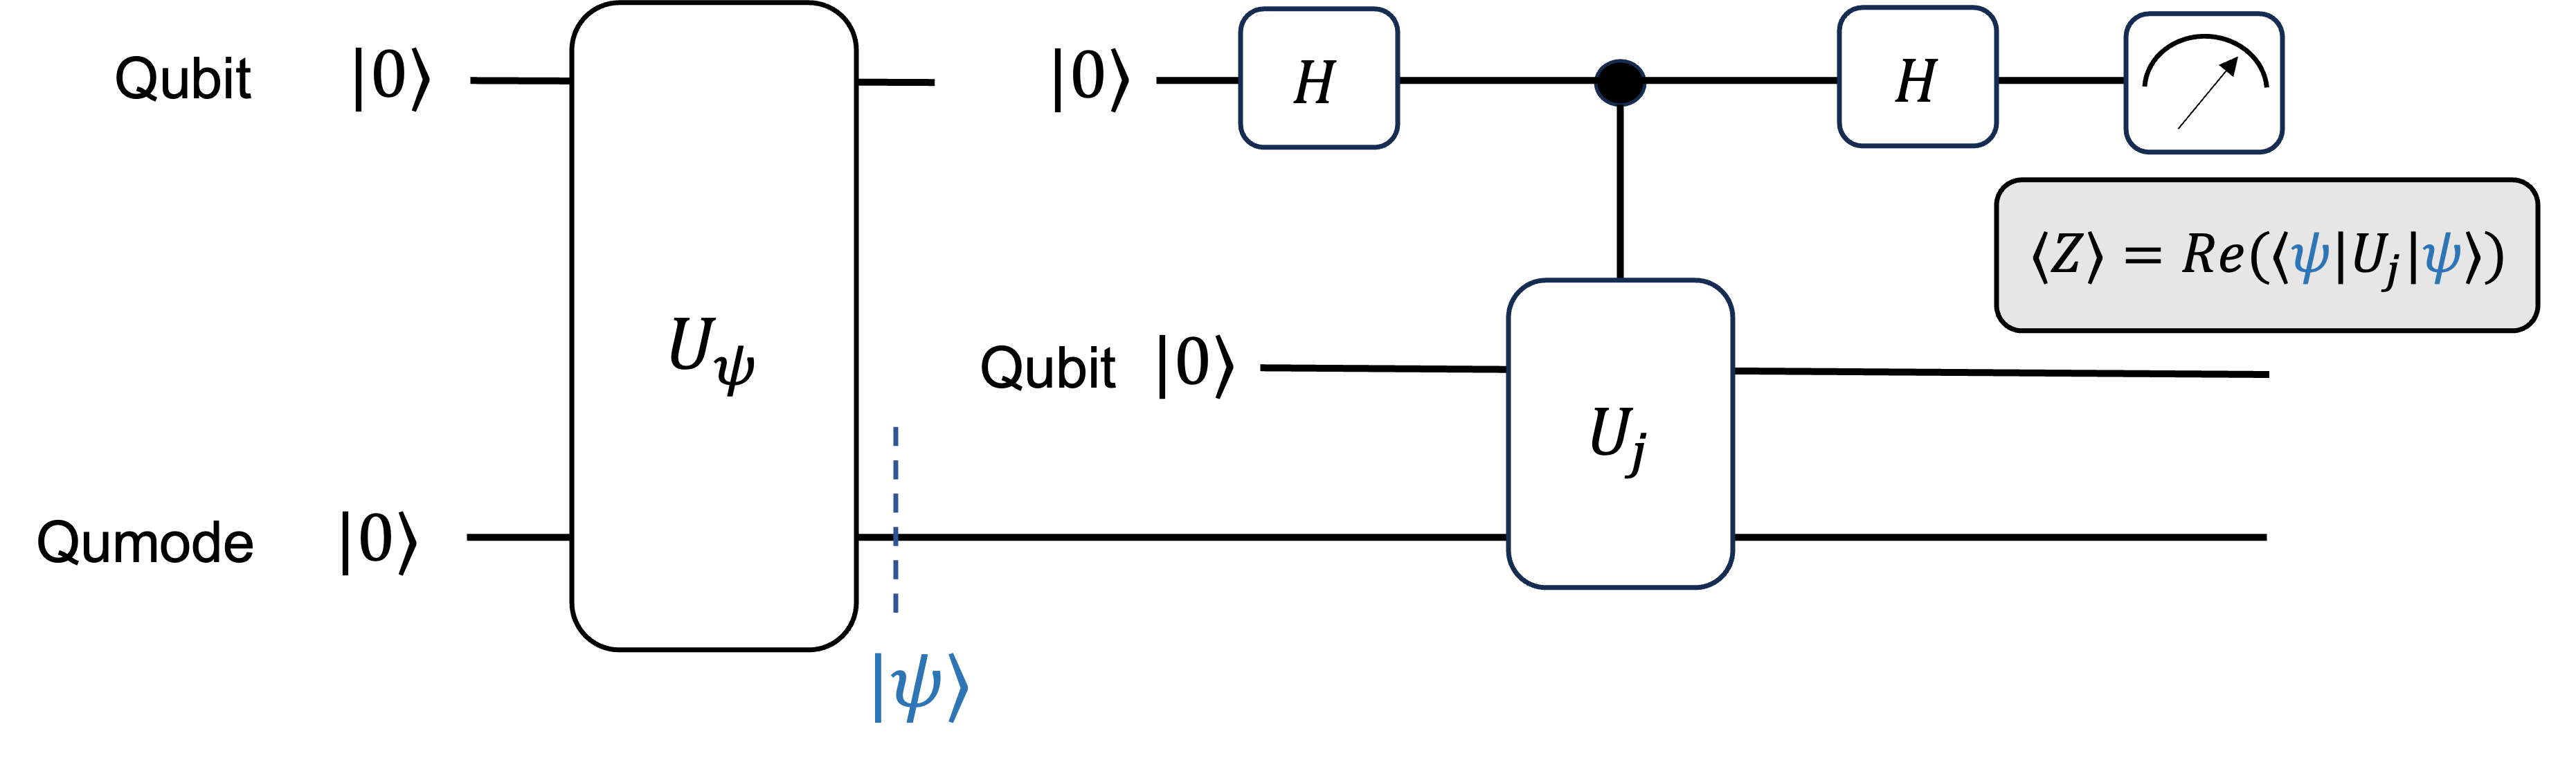

We can write the trial electronic energy of H$_2$ molecule by computing the expectation value of its molecular electronic structure Hamiltonian $H_Q$ under Jordan-Wigner transformation

\begin{align*}
\min_{\overrightarrow{\beta^{\psi}}, \overrightarrow{\theta^{\psi}}, \overrightarrow{\phi^{\psi}}} E
&= \langle \psi ( \overrightarrow{\beta^{\psi}}, \overrightarrow{\theta^{\psi}}, \overrightarrow{\phi^{\psi}} ) | \:
H_Q \:
|\psi ( \overrightarrow{\beta^{\psi}}, \overrightarrow{\theta^{\psi}}, \overrightarrow{\phi^{\psi}} ) \rangle
\\
&= \langle \psi | \:
\Big( g_1 + \sum_{p = 2}^8 \: g_p \: \hat{W}_p \Big) \:
| \psi \rangle
\\
&= g_1 + \sum_{p = 2}^8 \: g_p \:
\langle \psi | \: \hat{W}_p \: |\psi \rangle
\\
&= g_1 + \sum_{p = 2}^8 \: g_p \: w_p,
\end{align*}

where $\{ \hat{W}_p \}$ are four-qubit operators and $\{ g_p \}$ values are known from Hartree-Fock calculation.

The $\{ w_p \}$ values can be computed by

$$ w_p
= \sum_{j = 1}^{N_t} \: \lambda_{p, j} \:
\text{Re} \Big( \langle 0, \psi | \:
U_{j, p} ( \overrightarrow{\beta^{H}}, \overrightarrow{\theta^{H}}, \overrightarrow{\phi^{H}} ) \: |
0, \psi \rangle \Big)
= \sum_{j = 1}^{N_t} \: \lambda_j \: M_{p, j},
$$

where $\{ \lambda_{j, p} \}$ are known real-valued coefficients and $\{ M_{j, p} \}$ values can be computed in the hardware using the Hadamard test above.
Each of the $\{ U_{j, p} \}$ is an ECD-rotation circuit with known coefficients.

The qumode state is generated by tracing out the qubit-qumode state

$$ | \psi \rangle
\Leftarrow U_{\psi} ( \overrightarrow{\beta^{\psi}}, \overrightarrow{\theta^{\psi}}, \overrightarrow{\phi^{\psi}} ) \:
\Big( |0 \rangle_Q \otimes |0 \rangle_C \Big),
$$

where $U_{\psi}$ is a qubit-qumode unitary generated from an ECD-rotation circuit ansatz.

In [34]:
def include_hadamard(U):
    """
    Hadamard test involving a QuTip operator.
    """
    # Initialize
    dim = U.full().shape[0]
    hop = qt.Qobj(hadamard_np())

    # Build
    op1 = qt.tensor(hop, qt.qeye(dim))
    op2 = qt.tensor(qt.basis(2, 0).proj(), qt.qeye(dim))
    op2 += qt.tensor(qt.basis(2, 1).proj(), U)

    return op1 * op2 * op1

In [35]:
def psi_uni_psi_hadamard(state, U):
    """
    Expectation value.

    Arguments:
    state -- qubit-qumode state
    U -- qubit-qumode unitary
    """
    # Operators
    nfock = U.shape[0] // 2
    U = qt.Qobj(U)

    # |0> |state>
    fstate = qt.tensor(qt.basis(2, 0), state)

    # Hadamard-included operator
    T = include_hadamard(U)

    # T |fstate>
    psi = T * fstate

    # Extract qubit RDM
    qubit_rho = trace_out_qumode(psi, 2 * nfock)

    # <Z>
    ov = qt.expect(qt.sigmaz(), qubit_rho)

    return np.real(ov)

In [36]:
def psi_ham_term_psi_lcu_hadamard(Xvec, pind):
    # Check
    if pind < 2 or pind > 8:
        raise ValueError("Wrong pind in psi_ham_term_psi.")

    # Get parameters
    Lvec, Uten = ecd_params_ham_ops(pind)

    # Parameters
    nterms = Uten.shape[0]
    nfock = Uten.shape[1] // 2

    # Qumode state
    state = qumode_state_from_ecd(Xvec, nfock)

    # Final
    en = 0.0
    for i in range(nterms):
        en += ( Lvec[i] * psi_uni_psi_hadamard(state, Uten[i, :, :]) )

    return en

In [37]:
def energy_val(Xvec, gvec):
    """
    Energy function.

    Arguments:
    Xvec -- ansatz ECD-rotation parameters
    gvec -- Hamiltonian coefficients
    """
    en = gvec[0].copy()
    for i in range(1, 8):
        en += ( gvec[i] * psi_ham_term_psi_lcu_hadamard(Xvec, i+1) )

    return en

## VQE

In [38]:
def ecd_opt_vqe(hhdis, ndepth, maxiter=100, method='COBYLA', verbose=False, \
                threshold=1e-08, Xvec=[]):
    """
    Minimize the cost function using SciPy-based methods.

    Arguments:
    hhdis -- H-H bond distance in Angstrom
    ndepth -- ansatz circuit depth
    maxiter -- maximum number of iterations
    method -- optimization method
    threshold -- error tolerance
    Xvec -- optional initial guesses
    """
    # Hamiltonian parameters
    gvec = get_ham_coeffs(hhdis)

    # Bound parameters
    beta_mag_min = 0.0
    beta_mag_max = 10.0
    beta_arg_min = 0.0
    beta_arg_max = 2 * np.pi
    theta_min = 0.0
    theta_max = np.pi
    phi_min = 0.0
    phi_max = 2 * np.pi

    # Define bounds
    bounds = []
    for _ in range(ndepth):
        bounds.append([beta_mag_min, beta_mag_max])
    for _ in range(ndepth):
        bounds.append([beta_arg_min, beta_arg_max])
    for _ in range(ndepth):
        bounds.append([theta_min, theta_max])
    for _ in range(ndepth):
        bounds.append([phi_min, phi_max])
    bounds = np.array(bounds)

    # Guess
    if len(Xvec) == 0:
        beta_mag = np.random.uniform(0, 3, size=ndepth)
        beta_arg = np.random.uniform(0, np.pi, size=ndepth)
        theta = np.random.uniform(0, np.pi, size=ndepth)
        phi = np.random.uniform(0, np.pi, size=ndepth)
        Xvec = pack_params_np(beta_mag, beta_arg, theta, phi)

    # Loss function
    obj_fun = partial(energy_val, gvec=gvec)

    # Intermediate values
    def callback(xk):
        if verbose:
            print("-------------------")
            print(f"Current energy: {obj_fun(xk)}")

    # SciPy options
    options = {'disp': True, 'maxiter': maxiter}

    # Optimize
    if method == 'COBYLA':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'Powell':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'CG':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'BFGS':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'L-BFGS-B':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    elif method == 'TNC':
        result = sciopt.minimize(obj_fun, Xvec, method=method, \
                                 bounds=bounds, tol=threshold, callback=callback)
    elif method == 'trust-constr':
        result = sciopt.minimize(obj_fun, Xvec, method=method, bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)
    else:
        result = sciopt.minimize(obj_fun, Xvec, method='COBYLA', bounds=bounds, \
                                 tol=threshold, options=options, callback=callback)

    return result.fun, result.x

## Explore

For H-H bond distances = $ (0.25, 0.35, \cdots, 3.25) $.

In [ ]:
dis_angstrom = np.array([0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25,
       1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15, 2.25, 2.35,
       2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15, 3.25])

fci_en = np.array([-0.3122699 , -0.78926939, -0.9984156 , -1.09262991, -1.12990478,
       -1.13711707, -1.12836188, -1.11133942, -1.09034218, -1.06792966,
       -1.04578314, -1.02505436, -1.00648693, -0.99047634, -0.97712962,
       -0.96633454, -0.95783297, -0.95128976, -0.94634974, -0.94267779,
       -0.93998171, -0.93802086, -0.93660526, -0.93558937, -0.93486413,
       -0.93434899, -0.93398498, -0.93372922, -0.9335506 , -0.93342668,
       -0.93334128])

In [ ]:
nind = 0
ndepth = 9

en, Xvec = ecd_opt_vqe(dis_angstrom[nind], ndepth, maxiter=int(1e2), method='BFGS', \
                       verbose=True, threshold=1e-08)
en